In [5]:
import tensorflow
import numpy as np
import pandas as pd
import seaborn as sns
import random
from pyliftover import LiftOver
from sklearn.linear_model import LogisticRegression
from scipy import stats
import copy
sns.set_style("whitegrid")

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [20,15]
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.style.use('ggplot')

In [7]:
import scanpy as sc

In [8]:
tiles = '1000'

In [9]:
resources_dir = "/Volumes/broad_regevtmp/dsilverb/Glioma_scRRBS/resources/DNAmetBulkSignatures/"

# Read data

In [12]:
# Read training data
training_data = pd.read_table(resources_dir + "/preprocessed_data/bulk_tiles_L"+tiles+".csv", sep = "\t")


In [13]:
training_data.head()

,179842,195978,352814,390614,391631,459160,500479,535799,588911,590041,...,235650239,236167354,237042150,238289153,241357126,241559097,242524879,247111542,247857010,y
0,0.527956,0.065351,0.463090,0.048496,0.434076,0.028403,0.372314,0.126494,0.155793,0.284231,...,0.149098,0.422890,0.524072,0.175735,0.097019,0.085322,0.175146,0.045655,0.538191,LGm5
1,0.136991,0.093833,0.475833,0.122761,0.096342,0.039430,0.071684,0.500257,0.111992,0.114232,...,0.746733,0.038522,0.054411,0.428568,0.358777,0.440726,0.551330,0.048035,0.025628,LGm2
2,0.307928,0.305246,0.868638,0.390802,0.069497,0.034964,0.208377,0.870309,0.127856,0.085402,...,0.877951,0.044951,0.041703,0.596231,0.433103,0.464699,0.470406,0.026294,0.032970,LGm2
3,0.342348,0.082648,0.702991,0.635762,0.209455,0.058299,0.672201,0.516726,0.119815,0.145786,...,0.739108,0.063387,0.051595,0.229732,0.648278,0.636773,0.432394,0.041276,0.021361,LGm2
4,0.751240,0.175326,0.804799,0.654954,0.196321,0.286183,0.354373,0.594971,0.450331,0.334108,...,0.827405,0.111962,0.047647,0.640127,0.792073,0.460411,0.707254,0.305348,0.494138,LGm3


#### Deal with class imbalance by upsampling on training data if that is an issue 

In [14]:
### Upsample
from collections import Counter

values = Counter(training_data['y']).keys() # equals to list(set(words))
values_count = Counter(training_data['y']).values() # counts the elements' frequency

upsample_to = max(values_count)

from sklearn.utils import resample

training_data_upsampled = training_data

for i in range(len(values)):
    
    # get classes that need to be upsampled
    minority_count = list(values_count)[i]
    if (minority_count < upsample_to):
        
        # Get the samples
        training_data_minority = training_data[training_data['y']==(list(values)[i])]
        
        # resample from them
        minority_upsampled = resample(training_data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples= (upsample_to - minority_count),    # to match majority class
                                 random_state=123) # reproducible results
        training_data_upsampled = pd.concat([training_data_upsampled, minority_upsampled])


##### Order the columns based on names - so that the bulk and sc will have matching order

In [15]:
training_data = training_data_upsampled
Y = training_data['y']
del training_data['y']

In [16]:
training_data.shape

(1584, 996)

##### read sc data

In [18]:
df_sc = pd.read_table(resources_dir + "/preprocessed_data/sc_tiles_L"+tiles+".csv", sep="\t")

In [21]:
sc_filename = df_sc['filename']

In [22]:
df_sc = df_sc[training_data.columns]

##### Set class labels for sc

In [23]:
classifier_dict = {'MGH105A':'WT', 'MGH105B':'WT', 'MGH105C':'WT', 'MGH105Cmacrophage':'WT', 'MGH105D':'WT',
       'MGH107':'IDHmut', 'MGH115':'WT', 'MGH120':'IDHmut', 'MGH121Plate1':'WT', 'MGH121Plate2':'WT',
       'MGH121Plate3':'WT', 'MGH121Plate4':'WT', 'MGH122':'WT', 'MGH124':'WT', 'MGH129':'WT',
       'MGH135':'IDHmut', 'MGH137':'IDHmut', 'MGH170':'IDHmut', 'MGH45':'IDHmut', 'MGH64':'IDHmut'}

In [24]:
filenames = [filename.replace('GBM_',"") for filename in sc_filename]
filenames = [filename.replace('IDH_',"") for filename in filenames]
filenames = [filename.replace('-',"_") for filename in filenames]
filenames = [filename.replace('MGH121_',"MGH121") for filename in filenames]
filenames = [filename.replace('MGH105C_P8',"MGH105Cmacrophage") for filename in filenames]

df_sc.index = filenames

tumor = [s.split('_')[0] for s in df_sc.index]
sc_y = [classifier_dict[k] for k in tumor]

In [25]:
len(sc_y)

1156

### Pseudo bulk

In [26]:
df_sc['tumor'] = tumor

In [27]:
pseudo_bulk = df_sc.groupby('tumor').mean()

# Preprocess for LR

##### transform labels to numbers

In [29]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
Y_sc = label_encoder.fit_transform(sc_y)
Y_pseudo_bulk = label_encoder.fit_transform(pseudo_bulk.index.map(classifier_dict))


In [30]:
np.unique(Y)

array([0, 1, 2, 3, 4, 5])

### z score each probe

In [31]:
bulk_zscore = copy.deepcopy(training_data)

In [32]:
for probe in bulk_zscore.columns:
    bulk_zscore[probe] = (bulk_zscore[probe] - bulk_zscore[probe].mean())/bulk_zscore[probe].std(ddof=0)

In [33]:
sc_zscore = copy.deepcopy(df_sc)

In [34]:
sc_zscore = sc_zscore[bulk_zscore.columns]

In [35]:
# transform to bulk units (0 to 1 instead of 0 to 100)
sc_zscore = sc_zscore/100
pseudo_bulk = pseudo_bulk/100

In [38]:
for probe in pseudo_bulk.columns:
    pseudo_bulk[probe] = (pseudo_bulk[probe] - pseudo_bulk[probe].mean())/pseudo_bulk[probe].std(ddof=0)

In [39]:
for probe in sc_zscore.columns:
    sc_zscore[probe] = (sc_zscore[probe] - sc_zscore[probe].mean())/sc_zscore[probe].std(ddof=0)

### impute missing values

In [40]:
from fancyimpute import KNN    


Using TensorFlow backend.


In [41]:
bulk_imputed = KNN(k=5).fit_transform(training_data)
bulk_zscore_imputed = KNN(k=5).fit_transform(bulk_zscore)
sc_zcore_imputed = KNN(k=5).fit_transform(sc_zscore)
df_sc_imputed = KNN(k=5).fit_transform(df_sc[bulk_zscore.columns])
pseudo_bulk_imputed = KNN(k=5).fit_transform(pseudo_bulk)

//anaconda3/lib/python3.7/site-packages/fancyimpute/solver.py:55: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")


Imputing row 1/1584 with 0 missing, elapsed time: 11.314
Imputing row 101/1584 with 0 missing, elapsed time: 11.315
Imputing row 201/1584 with 0 missing, elapsed time: 11.316
Imputing row 301/1584 with 0 missing, elapsed time: 11.317
Imputing row 401/1584 with 0 missing, elapsed time: 11.317
Imputing row 501/1584 with 0 missing, elapsed time: 11.318
Imputing row 601/1584 with 0 missing, elapsed time: 11.319
Imputing row 701/1584 with 0 missing, elapsed time: 11.319
Imputing row 801/1584 with 0 missing, elapsed time: 11.320
Imputing row 901/1584 with 0 missing, elapsed time: 11.320
Imputing row 1001/1584 with 0 missing, elapsed time: 11.321
Imputing row 1101/1584 with 0 missing, elapsed time: 11.322
Imputing row 1201/1584 with 0 missing, elapsed time: 11.323
Imputing row 1301/1584 with 0 missing, elapsed time: 11.323
Imputing row 1401/1584 with 0 missing, elapsed time: 11.324
Imputing row 1501/1584 with 0 missing, elapsed time: 11.325


#### Explore the data - plot heatmaps

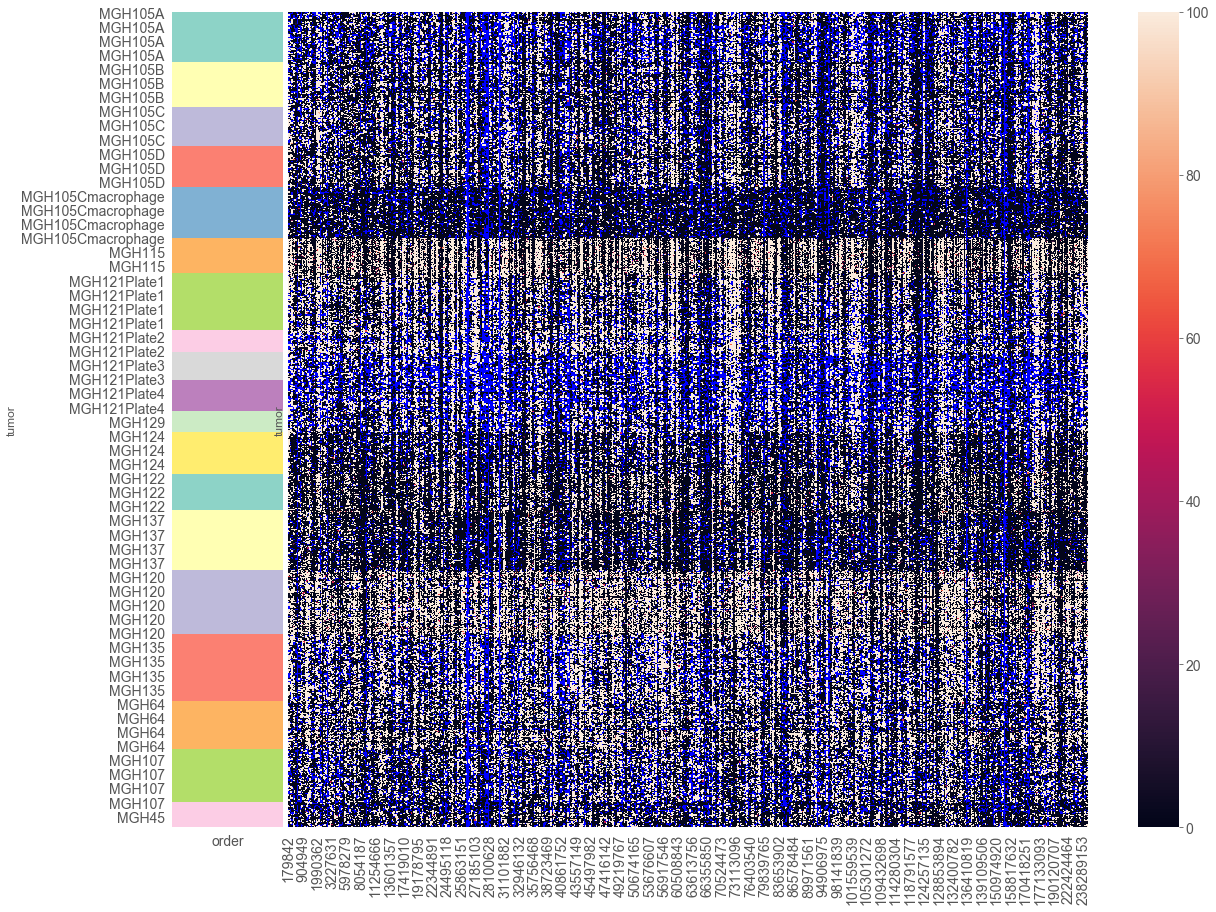

In [44]:
df_sc_copy = copy.deepcopy(df_sc)
custom_dict = {'MGH105A':1,'MGH105B':2,'MGH105C':3,'MGH105D':4,'MGH105Cmacrophage':5,'MGH115':6,
               'MGH121Plate1':7, 'MGH121Plate2':8,'MGH121Plate3':9, 'MGH121Plate4':10, 'MGH122':13, 'MGH124':12, 
               'MGH129':11,'MGH137':14,'MGH120':15,'MGH135':16,'MGH170':17,'MGH64':18,'MGH107':19,'MGH45':20}
df_sc_copy['order'] = [custom_dict[k] for k in df_sc_copy['tumor']]
df_sc_copy = df_sc_copy.sort_values('order')
df_sc_copy.index = df_sc_copy['tumor']

fig, (ax,ax2) = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [1, 9]})
fig.subplots_adjust(wspace=0.01)
sns.heatmap(df_sc_copy[['order']], ax=ax, cbar=False,cmap=sns.color_palette("Set3", len(df_sc_copy[['order']].drop_duplicates())+1))
g = sns.heatmap(df_sc_copy[training_data.columns], ax=ax2, cbar=True, yticklabels = False, mask = (df_sc_copy[training_data.columns]).isnull())
#sns.heatmap(bulk_results[['predicted_class']], ax=ax3, cbar=False,cmap="tab20")
g.set_facecolor('blue')

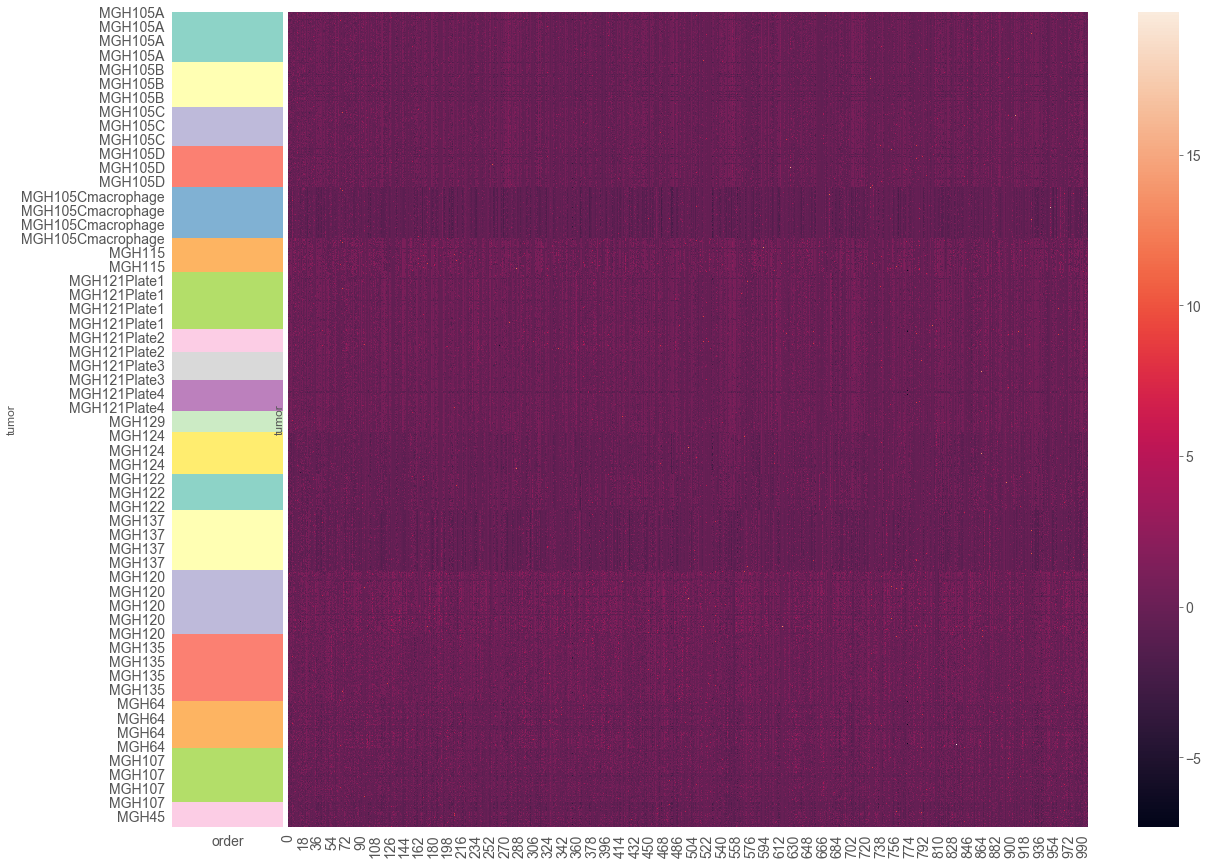

In [45]:

plot_tiles = pd.concat([df_sc['tumor'].reset_index(), pd.DataFrame(sc_zcore_imputed)], axis = 1)
custom_dict = {'MGH105A':1,'MGH105B':2,'MGH105C':3,'MGH105D':4,'MGH105Cmacrophage':5,'MGH115':6,
               'MGH121Plate1':7, 'MGH121Plate2':8,'MGH121Plate3':9, 'MGH121Plate4':10, 'MGH122':13, 'MGH124':12, 
               'MGH129':11,'MGH137':14,'MGH120':15,'MGH135':16,'MGH170':17,'MGH64':18,'MGH107':19,'MGH45':20}
plot_tiles['order'] = [custom_dict[k] for k in plot_tiles['tumor']]
plot_tiles = plot_tiles.sort_values('order')

plot_tiles.index = plot_tiles['tumor']
# Plot tiles
plot_columns = [e for e in plot_tiles.columns if e not in ('tumor', 'order','index')]
fig, (ax,ax2) = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [1, 9]})
fig.subplots_adjust(wspace=0.01)
sns.heatmap(plot_tiles[['order']], ax=ax, cbar=False,cmap=sns.color_palette("Set3", len(plot_tiles[['order']].drop_duplicates())+1))
g = sns.heatmap(plot_tiles[plot_columns], ax=ax2, cbar=True, yticklabels = False, mask = (plot_tiles[plot_columns]).isnull())
#sns.heatmap(bulk_results[['predicted_class']], ax=ax3, cbar=False,cmap="tab20")
g.set_facecolor('blue')

# Train classifier on bulk, and predict various sc options

In [47]:
sc_tumor = pd.DataFrame(df_sc['tumor']).reset_index()

In [48]:
sc_tumor = sc_tumor.drop(columns = 'index')

### train with bulk, predict pseudo bulk

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


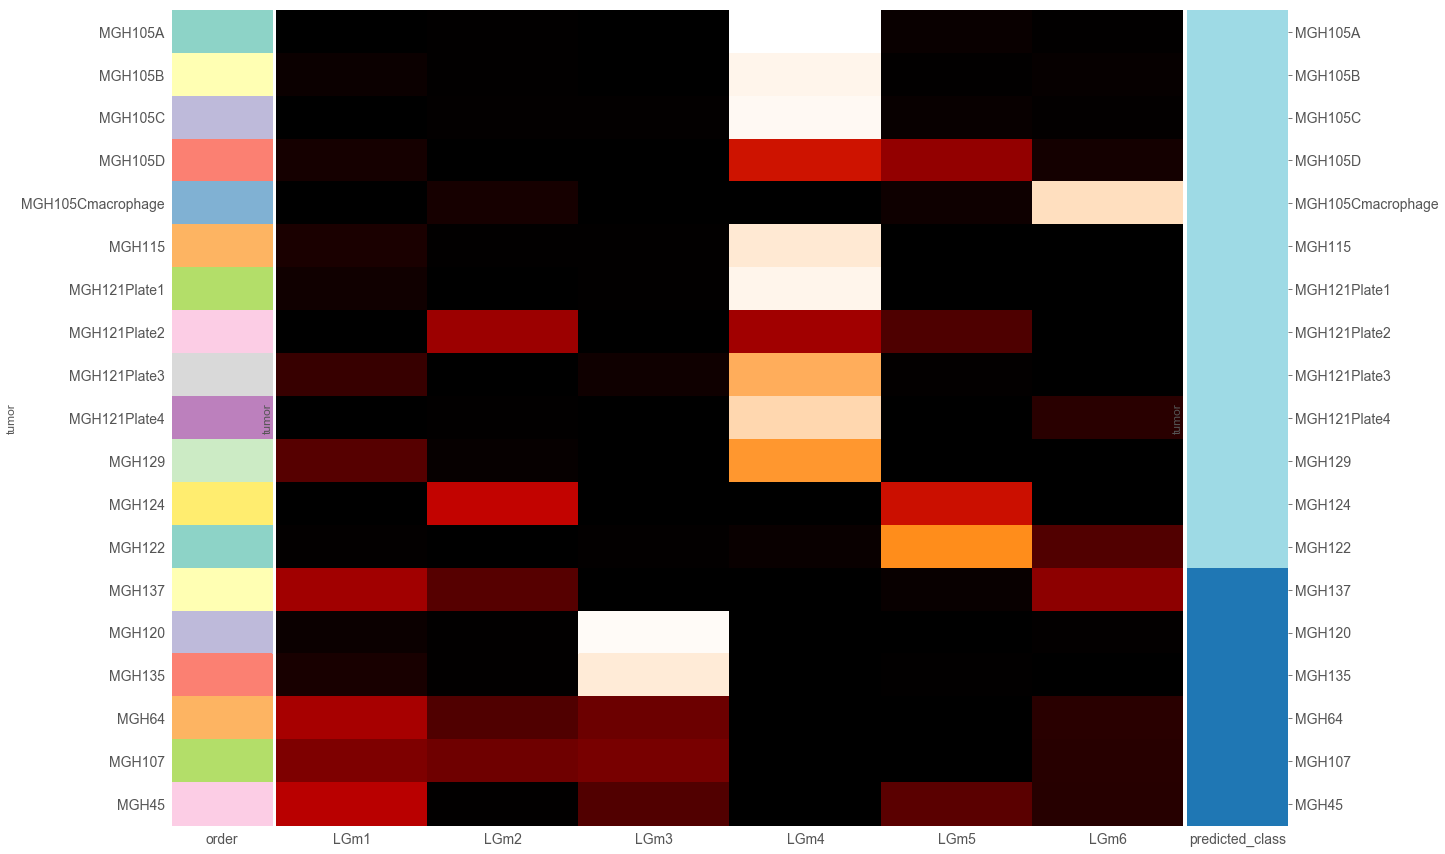

In [49]:
C = 1
logisticRegr = LogisticRegression(C = C)
logisticRegr.fit(bulk_zscore_imputed, Y)
sc_proba = logisticRegr.predict_proba(pseudo_bulk_imputed)
bulk_results = pd.concat([pd.DataFrame(np.unique(sc_tumor)), pd.DataFrame(sc_proba)], axis = 1)

bulk_results.columns= ['tumor','LGm1','LGm2','LGm3','LGm4','LGm5','LGm6']

bulk_results['Y'] = bulk_results['tumor'].map(classifier_dict)
bulk_results.columns= ['tumor','LGm1','LGm2','LGm3','LGm4','LGm5','LGm6','Y']

bulk_results['predicted_class'] = label_encoder.fit_transform(bulk_results['Y'])
custom_dict = {'MGH105A':1,'MGH105B':2,'MGH105C':3,'MGH105D':4,'MGH105Cmacrophage':5,'MGH115':6,
               'MGH121Plate1':7, 'MGH121Plate2':8,'MGH121Plate3':9, 'MGH121Plate4':10, 'MGH122':13, 'MGH124':12, 
               'MGH129':11,'MGH137':14,'MGH120':15,'MGH135':16,'MGH170':17,'MGH64':18,'MGH107':19,'MGH45':20}
bulk_results['order'] = [custom_dict[k] for k in bulk_results['tumor']]
bulk_results = bulk_results.sort_values('order')
bulk_results.index = bulk_results['tumor']


fig, (ax,ax2,ax3) = plt.subplots(ncols=3, gridspec_kw={'width_ratios': [1, 9,1]})
fig.subplots_adjust(wspace=0.01)
sns.heatmap(bulk_results[['order']], ax=ax, cbar=False,cmap=sns.color_palette("Set3", len(bulk_results[['order']].drop_duplicates())+1))
sns.heatmap(bulk_results[['LGm1','LGm2','LGm3','LGm4','LGm5','LGm6']], ax=ax2, cbar=False, yticklabels = False,cmap='gist_heat')
sns.heatmap(bulk_results[['predicted_class']], ax=ax3, cbar=False,cmap="tab20")

#fig.colorbar(ax2.collections[0], location="right", use_gridspec=False, pad=0.3)
ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
ax3.yaxis.tick_right()
ax3.tick_params(rotation=0)
#plt.savefig(figures_dir + "heatmap_pseudo_bulk_tiles"+ tiles +"C" + str(C).replace(".","_") + ".pdf")
plt.show()

In [50]:
bulk_results['sample'] = bulk_results['tumor']
bulk_results['sample'] = bulk_results['sample'].replace("MGH121Plate1","MGH121")
bulk_results['sample'] = bulk_results['sample'].replace("MGH121Plate2","MGH121")
bulk_results['sample'] = bulk_results['sample'].replace("MGH121Plate3","MGH121")
bulk_results['sample'] = bulk_results['sample'].replace("MGH121Plate4","MGH121")

bulk_results['sample'] = bulk_results['sample'].replace("MGH105A","MGH105")
bulk_results['sample'] = bulk_results['sample'].replace("MGH105B","MGH105")
bulk_results['sample'] = bulk_results['sample'].replace("MGH105C","MGH105")
bulk_results['sample'] = bulk_results['sample'].replace("MGH105D","MGH105")

### train with bulk, predict sc without zscoring

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


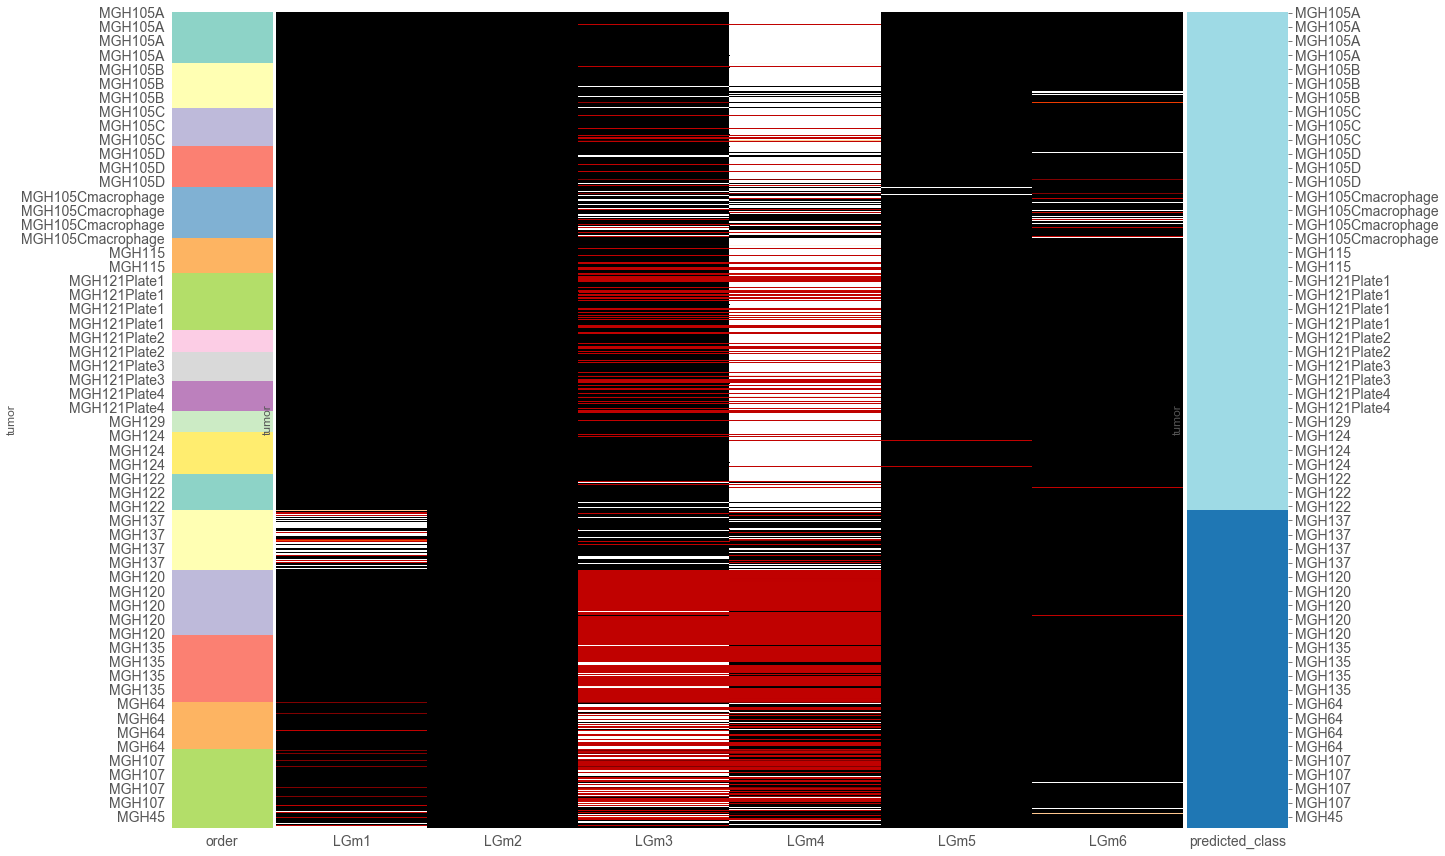

In [51]:
C = 1
logisticRegr = LogisticRegression(C = C)
logisticRegr.fit(bulk_imputed, Y)
sc_proba = logisticRegr.predict_proba(df_sc_imputed)
results = pd.concat([sc_tumor, pd.DataFrame(sc_proba)], axis = 1)
results['Y'] = results['tumor'].map(classifier_dict)

results.columns= ['tumor','LGm1','LGm2','LGm3','LGm4','LGm5','LGm6','Y']


results['filename'] = sc_zscore.index

results['predicted_class'] = label_encoder.fit_transform(results['Y'])
custom_dict = {'MGH105A':1,'MGH105B':2,'MGH105C':3,'MGH105D':4,'MGH105Cmacrophage':5,'MGH115':6,
               'MGH121Plate1':7, 'MGH121Plate2':8,'MGH121Plate3':9, 'MGH121Plate4':10, 'MGH122':13, 'MGH124':12, 
               'MGH129':11,'MGH137':14,'MGH120':15,'MGH135':16,'MGH170':17,'MGH64':18,'MGH107':19,'MGH45':20}
results['order'] = [custom_dict[k] for k in results['tumor']]
results = results.sort_values('order')
results.index = results['tumor']
results['filename'] = results['filename'].str.rstrip(".R1.fastq_bismark_bt2_pe.bismark.cov")
results['filename'] = results['filename'].replace({'Plate':'_Plate'}, regex=True)


fig, (ax,ax2,ax3) = plt.subplots(ncols=3, gridspec_kw={'width_ratios': [1, 9,1]})
fig.subplots_adjust(wspace=0.01)
sns.heatmap(results[['order']], ax=ax, cbar=False,cmap=sns.color_palette("Set3", len(results[['order']].drop_duplicates())))
sns.heatmap(results[['LGm1','LGm2','LGm3','LGm4','LGm5','LGm6']], ax=ax2, cbar=False, yticklabels = False,cmap='gist_heat')
sns.heatmap(results[['predicted_class']], ax=ax3, cbar=False,cmap="tab20")

#fig.colorbar(ax2.collections[0], location="right", use_gridspec=False, pad=0.3)
ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
ax3.yaxis.tick_right()
ax3.tick_params(rotation=0)
#plt.savefig(figures_dir + "heatmap_tiles"+ tiles +"C" + str(C).replace(".","_") + ".pdf")
plt.show()


### train with bulk, predict zscored sc

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


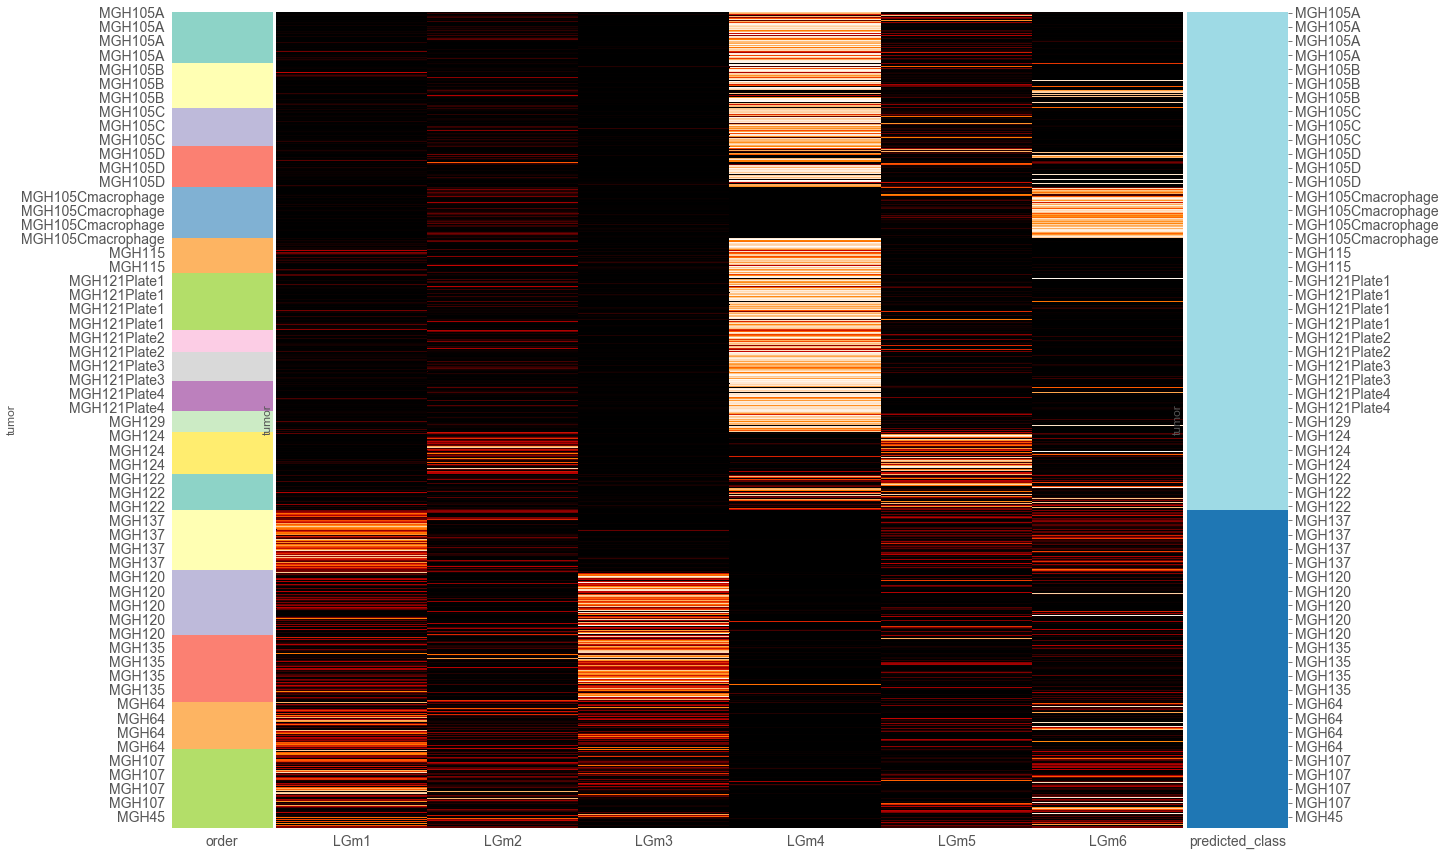

In [53]:
C = 1
logisticRegr = LogisticRegression(C = C)
logisticRegr.fit(bulk_zscore_imputed, Y)
sc_proba = logisticRegr.predict_proba(sc_zcore_imputed)
results = pd.concat([sc_tumor, pd.DataFrame(sc_proba)], axis = 1)
results['Y'] = results['tumor'].map(classifier_dict)

results.columns= ['tumor','LGm1','LGm2','LGm3','LGm4','LGm5','LGm6','Y']


results['filename'] = sc_zscore.index

results['predicted_class'] = label_encoder.fit_transform(results['Y'])
custom_dict = {'MGH105A':1,'MGH105B':2,'MGH105C':3,'MGH105D':4,'MGH105Cmacrophage':5,'MGH115':6,
               'MGH121Plate1':7, 'MGH121Plate2':8,'MGH121Plate3':9, 'MGH121Plate4':10, 'MGH122':13, 'MGH124':12, 
               'MGH129':11,'MGH137':14,'MGH120':15,'MGH135':16,'MGH170':17,'MGH64':18,'MGH107':19,'MGH45':20}
results['order'] = [custom_dict[k] for k in results['tumor']]
results = results.sort_values('order')
results.index = results['tumor']
results['filename'] = results['filename'].str.rstrip(".R1.fastq_bismark_bt2_pe.bismark.cov")
results['filename'] = results['filename'].replace({'Plate':'_Plate'}, regex=True)


fig, (ax,ax2,ax3) = plt.subplots(ncols=3, gridspec_kw={'width_ratios': [1, 9,1]})
fig.subplots_adjust(wspace=0.01)
sns.heatmap(results[['order']], ax=ax, cbar=False,cmap=sns.color_palette("Set3", len(results[['order']].drop_duplicates())))
sns.heatmap(results[['LGm1','LGm2','LGm3','LGm4','LGm5','LGm6']], ax=ax2, cbar=False, yticklabels = False,cmap='gist_heat')
sns.heatmap(results[['predicted_class']], ax=ax3, cbar=False,cmap="tab20")

#fig.colorbar(ax2.collections[0], location="right", use_gridspec=False, pad=0.3)
ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
ax3.yaxis.tick_right()
ax3.tick_params(rotation=0)
#plt.savefig(figures_dir + "heatmap_tiles"+ tiles +"C" + str(C).replace(".","_") + ".pdf")
plt.show()

### using 10 fold cross validation, train on 9/10 bulk, and test on 1/10 bulk, on a range of C parameters

In [54]:
from sklearn.model_selection import cross_val_score

c_range = [1000000,100000,10000,1000,100,10,1,0.1,0.01,0.001,0.0001]

# empty list to store scores
C_scores = []

# we will loop through reasonable values of k
for c in c_range:

    # Train with currrent C
    logisticRegr = LogisticRegression(C = c)
    
    # obtain cross_val_score for logictic regression with current C
    scores = cross_val_score(logisticRegr, bulk_zscore_imputed, Y, cv=10, scoring='balanced_accuracy')
    
    # 4. append mean of scores for C neighbors to C_scores list
    C_scores.append(scores.mean())
    

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be ch

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be ch

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be ch

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be ch

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be ch

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be ch

([<matplotlib.axis.XTick at 0x1c32044210>,
 <a list of 11 Text xticklabel objects>)

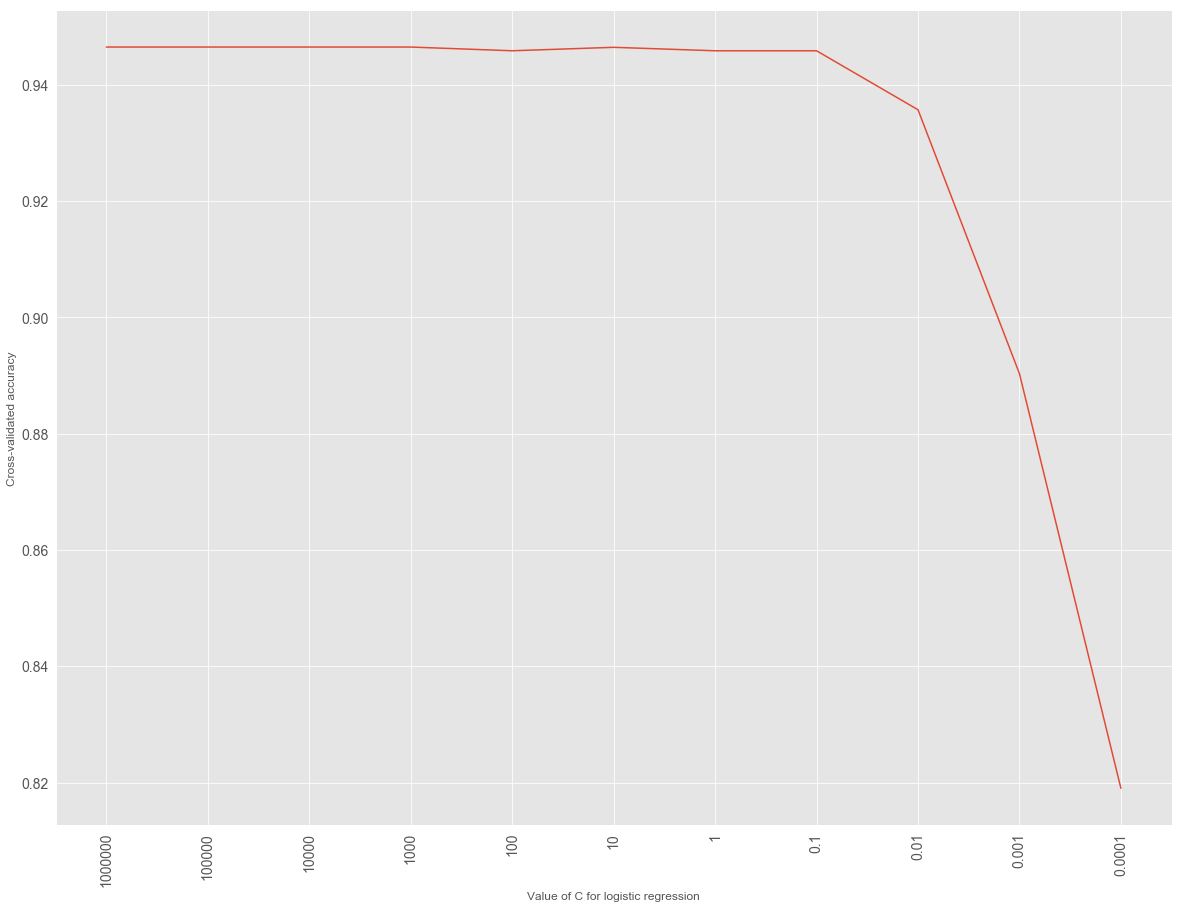

In [55]:
plt.plot(range(0,len(c_range)), C_scores)
plt.xlabel('Value of C for logistic regression')
plt.ylabel('Cross-validated accuracy')
plt.xticks(range(0,len(c_range)), c_range, rotation='vertical')


# SC AUC

### GBM vs IDH

In [56]:
from sklearn import metrics

In [57]:
IDH_proba = results[['LGm6','LGm4','LGm5']].max(axis = 1)

In [58]:
classifier_dict = {'MGH105A':'WT', 'MGH105B':'WT', 'MGH105C':'WT', 'MGH105Cmacrophage':'WT', 'MGH105D':'WT',
       'MGH107':'IDHmut', 'MGH115':'WT', 'MGH120':'IDHmut', 'MGH121Plate1':'WT', 'MGH121Plate2':'WT',
       'MGH121Plate3':'WT', 'MGH121Plate4':'WT', 'MGH122':'WT', 'MGH124':'WT', 'MGH129':'WT',
       'MGH135':'IDHmut', 'MGH137':'IDHmut', 'MGH170':'IDHmut', 'MGH45':'IDHmut', 'MGH64':'IDHmut'}

In [59]:
# Remove macrophages, highgrade and treated
results_for_auc = results[~results['tumor'].isin(["MGH137","MGH170","MGH105Cmacrophage"])]
IDH_proba_for_auc = IDH_proba[~results['tumor'].isin(["MGH137","MGH170","MGH105Cmacrophage"])]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


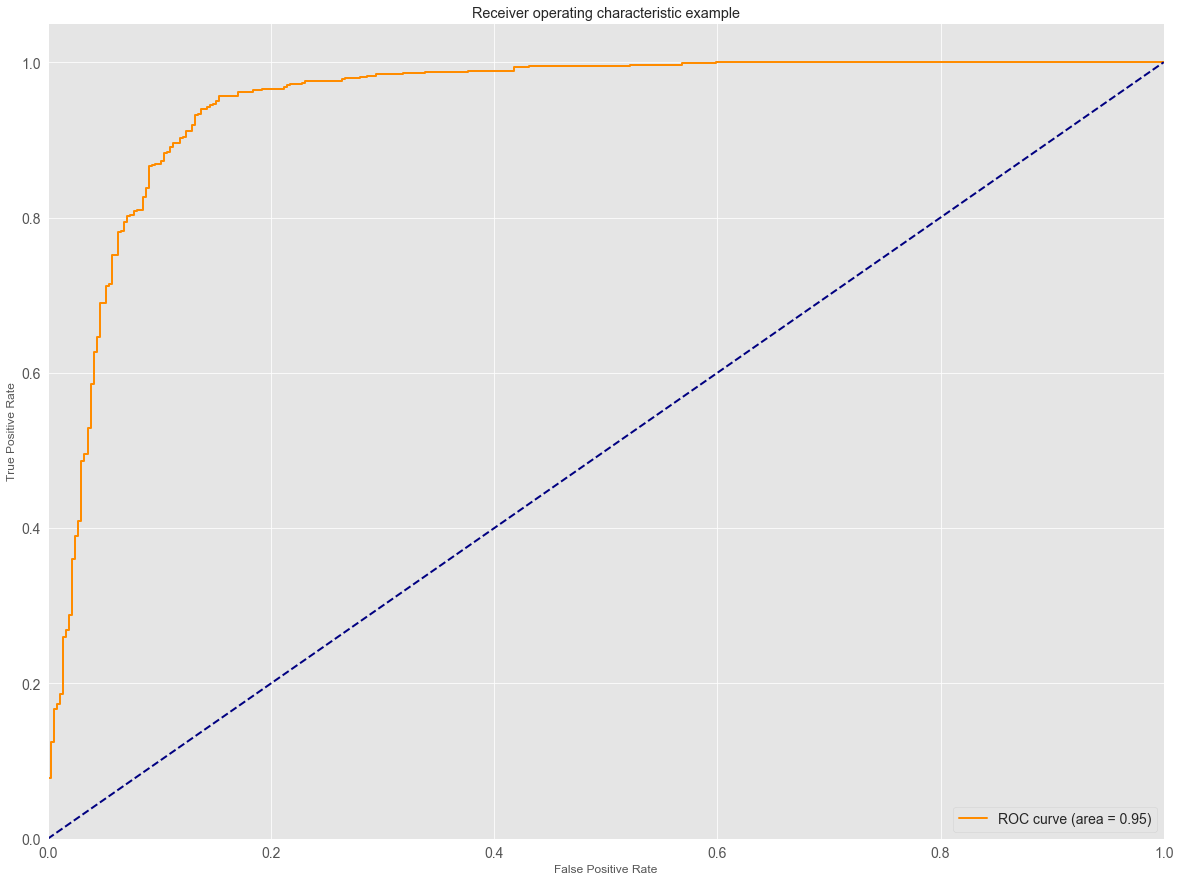

In [60]:
results_for_auc['Y'] = results_for_auc['tumor'].map(classifier_dict)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = metrics.roc_curve(label_encoder.fit_transform(results_for_auc['Y']),IDH_proba_for_auc)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Oligodendroglioma

In [61]:

classifier_dict = {'MGH105A':'WT', 'MGH105B':'WT', 'MGH105C':'WT', 'MGH105Cmacrophage':'WT', 'MGH105D':'WT',
       'MGH107':'IDHmut-non-codel', 'MGH115':'WT', 'MGH120':'IDHmut-codel', 'MGH121Plate1':'WT', 'MGH121Plate2':'WT',
       'MGH121Plate3':'WT', 'MGH121Plate4':'WT', 'MGH122':'WT', 'MGH124':'WT', 'MGH129':'WT',
       'MGH135':'IDHmut-codel', 'MGH137':'IDHmut-non-codel', 'MGH170':'IDHmut-codel', 'MGH45':'IDHmut-non-codel', 'MGH64':'IDHmut-non-codel'}

#classifier_dict = {'MGH135':'IDHmut-codel', 'MGH107':'IDHmut-non-codel','MGH45':'IDHmut-non-codel','MGH64':'IDHmut-non-codel','MGH43':'IDHmut-non-codel','MGH120':'IDHmut-codel','MGH170':'IDHmut-codel','MGH137':'IDHmut-non-codel'}


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


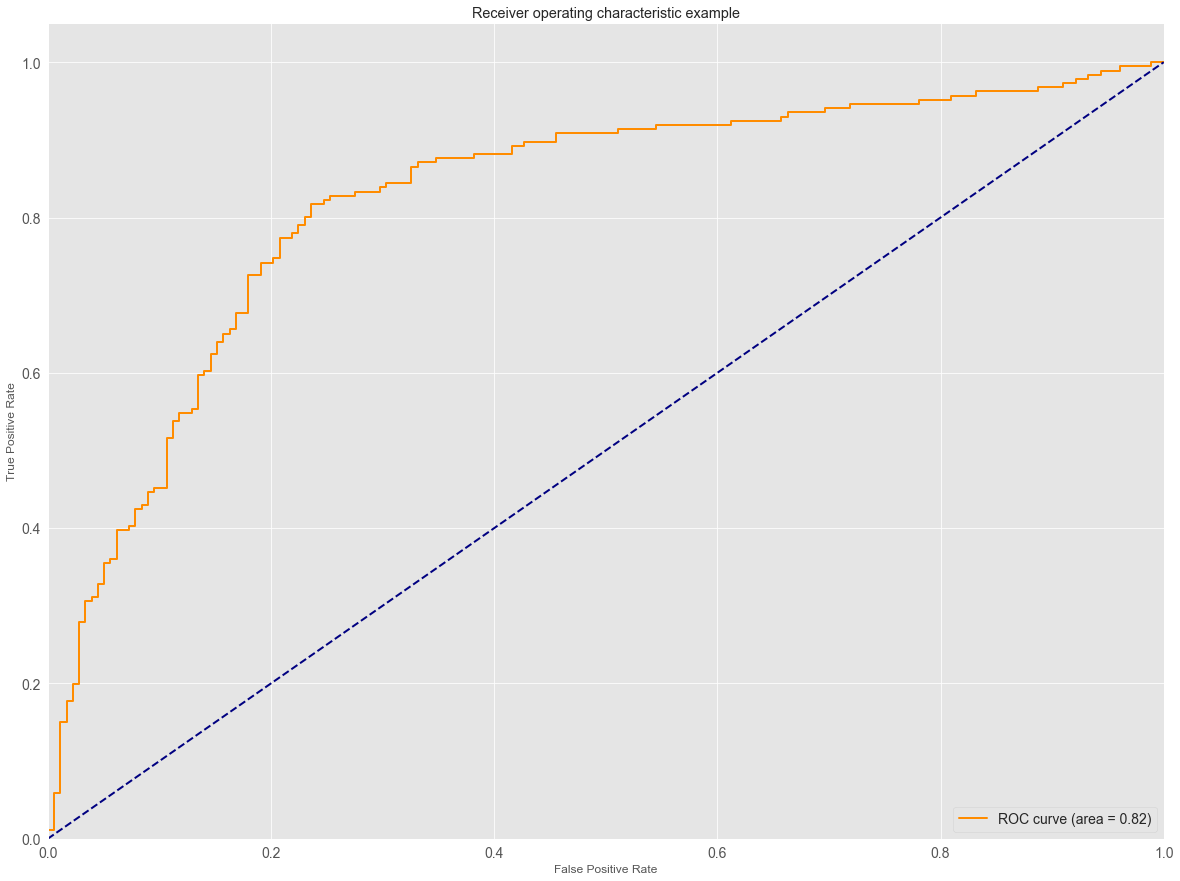

In [62]:
# Remove macrophages, highgrade and treated
results_for_auc = results[~results['tumor'].isin(["MGH137","MGH170","MGH105Cmacrophage"])]

results_for_auc['Y'] = results_for_auc['tumor'].map(classifier_dict)
CoDel_results = results_for_auc[results_for_auc['Y'] != 'WT']

CoDel_proba = CoDel_results[['LGm2','LGm3']].max(axis = 1)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = metrics.roc_curve(1-label_encoder.fit_transform(CoDel_results['Y']),CoDel_proba)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Astrocytoma

In [63]:
np.unique(CoDel_proba.index)

CoDel_proba = CoDel_results[['LGm1','LGm2']].max(axis = 1)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = metrics.roc_curve(label_encoder.fit_transform(CoDel_results['Y']),CoDel_proba)
roc_auc = metrics.auc(fpr, tpr)

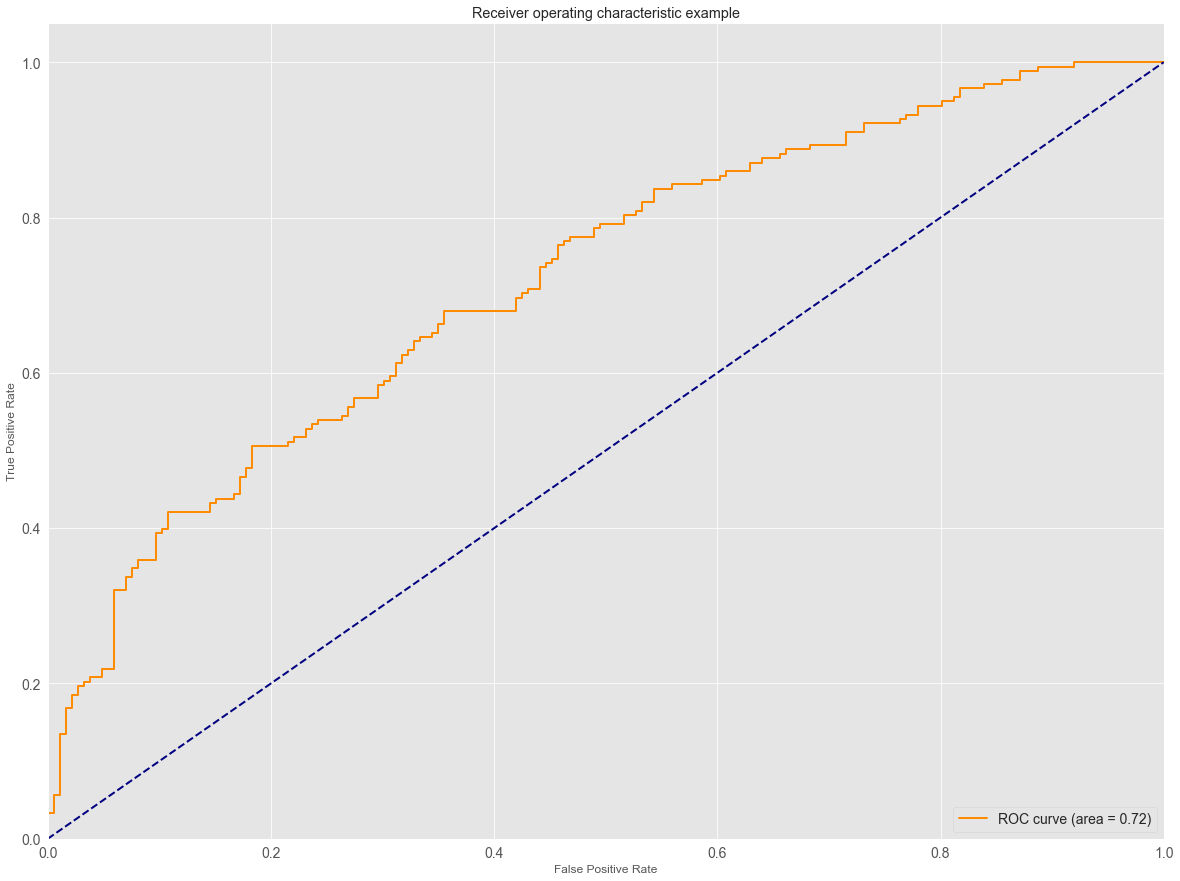

In [64]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Change K in KNN and C, and see how it impacts the sc AUC

In [66]:
def test_k(K = 5, C = 0.001):

    bulk_zscore_imputed = KNN(k=K).fit_transform(bulk_zscore)
    sc_zcore_imputed = KNN(k=K).fit_transform(sc_zscore)
    logisticRegr = LogisticRegression(C = C)
    logisticRegr.fit(bulk_zscore_imputed, Y)
    sc_proba = logisticRegr.predict_proba(sc_zcore_imputed)
    results = pd.concat([sc_tumor, pd.DataFrame(sc_proba)], axis = 1)
    #results['Y'] = results['tumor'].map(classifier_dict)
    results.columns= ['tumor','LGm1','LGm2','LGm3','LGm4','LGm5','LGm6']
    #results['filename'] = sc_zscore.index

    #results['predicted_class'] = label_encoder.fit_transform(results['Y'])

    IDH_proba = results[['LGm6','LGm4','LGm5']].max(axis = 1)
    classifier_dict = {'MGH105A':'WT', 'MGH105B':'WT', 'MGH105C':'WT', 'MGH105Cmacrophage':'WT', 'MGH105D':'WT',
           'MGH107':'IDHmut', 'MGH115':'WT', 'MGH120':'IDHmut', 'MGH121Plate1':'WT', 'MGH121Plate2':'WT',
           'MGH121Plate3':'WT', 'MGH121Plate4':'WT', 'MGH122':'WT', 'MGH124':'WT', 'MGH129':'WT',
           'MGH135':'IDHmut', 'MGH137':'IDHmut', 'MGH170':'IDHmut', 'MGH45':'IDHmut', 'MGH64':'IDHmut'}
    # Remove macrophages, highgrade and treated
    results_for_auc = results[~results['tumor'].isin(["MGH137","MGH170","MGH105Cmacrophage"])]
    IDH_proba_for_auc = IDH_proba[~results['tumor'].isin(["MGH137","MGH170","MGH105Cmacrophage"])]
    results_for_auc['Y'] = results_for_auc['tumor'].map(classifier_dict)

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = metrics.roc_curve(label_encoder.fit_transform(results_for_auc['Y']),IDH_proba_for_auc)
    IDH_roc_auc = metrics.auc(fpr, tpr)

    classifier_dict = {'MGH105A':'WT', 'MGH105B':'WT', 'MGH105C':'WT', 'MGH105Cmacrophage':'WT', 'MGH105D':'WT',
           'MGH107':'IDHmut-non-codel', 'MGH115':'WT', 'MGH120':'IDHmut-codel', 'MGH121Plate1':'WT', 'MGH121Plate2':'WT',
           'MGH121Plate3':'WT', 'MGH121Plate4':'WT', 'MGH122':'WT', 'MGH124':'WT', 'MGH129':'WT',
           'MGH135':'IDHmut-codel', 'MGH137':'IDHmut-non-codel', 'MGH170':'IDHmut-codel', 'MGH45':'IDHmut-non-codel', 'MGH64':'IDHmut-non-codel'}
    # Remove macrophages, highgrade and treated
    results_for_auc = results[~results['tumor'].isin(["MGH137","MGH170","MGH105Cmacrophage"])]

    results_for_auc['Y'] = results_for_auc['tumor'].map(classifier_dict)
    CoDel_results = results_for_auc[results_for_auc['Y'] != 'WT']

    CoDel_proba = CoDel_results[['LGm2','LGm3']].max(axis = 1)

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = metrics.roc_curve(1-label_encoder.fit_transform(CoDel_results['Y']),CoDel_proba)
    oligo_roc_auc = metrics.auc(fpr, tpr)

    CoDel_proba = CoDel_results[['LGm1','LGm2']].max(axis = 1)

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = metrics.roc_curve(label_encoder.fit_transform(CoDel_results['Y']),CoDel_proba)
    astro_roc_auc = metrics.auc(fpr, tpr)
    return(IDH_roc_auc,oligo_roc_auc,astro_roc_auc)

In [67]:
roc_2 = test_k(K = 2)
roc_3 = test_k(K = 3)
roc_5 = test_k(K = 5)
roc_10 = test_k(K = 10)
roc_20 = test_k(K = 20)
roc_4 = test_k(K = 4)
roc_6 = test_k(K = 6)
roc_7 = test_k(K = 7)
roc_8 = test_k(K = 8)
roc_9 = test_k(K = 9)

//anaconda3/lib/python3.7/site-packages/fancyimpute/solver.py:55: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")


Imputing row 1/1584 with 0 missing, elapsed time: 10.930
Imputing row 101/1584 with 0 missing, elapsed time: 10.931
Imputing row 201/1584 with 0 missing, elapsed time: 10.932
Imputing row 301/1584 with 0 missing, elapsed time: 10.932
Imputing row 401/1584 with 0 missing, elapsed time: 10.933
Imputing row 501/1584 with 0 missing, elapsed time: 10.934
Imputing row 601/1584 with 0 missing, elapsed time: 10.934
Imputing row 701/1584 with 0 missing, elapsed time: 10.935
Imputing row 801/1584 with 0 missing, elapsed time: 10.936
Imputing row 901/1584 with 0 missing, elapsed time: 10.936
Imputing row 1001/1584 with 0 missing, elapsed time: 10.937
Imputing row 1101/1584 with 0 missing, elapsed time: 10.938
Imputing row 1201/1584 with 0 missing, elapsed time: 10.939
Imputing row 1301/1584 with 0 missing, elapsed time: 10.939
Imputing row 1401/1584 with 0 missing, elapsed time: 10.940
Imputing row 1501/1584 with 0 missing, elapsed time: 10.940
Imputing row 1/1156 with 798 missing, elapsed time: 

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Imputing row 1/1584 with 0 missing, elapsed time: 10.208
Imputing row 101/1584 with 0 missing, elapsed time: 10.208
Imputing row 201/1584 with 0 missing, elapsed time: 10.209
Imputing row 301/1584 with 0 missing, elapsed time: 10.210
Imputing row 401/1584 with 0 missing, elapsed time: 10.210
Imputing row 501/1584 with 0 missing, elapsed time: 10.211
Imputing row 601/1584 with 0 missing, elapsed time: 10.212
Imputing row 701/1584 with 0 missing, elapsed time: 10.212
Imputing row 801/1584 with 0 missing, elapsed time: 10.213
Imputing row 901/1584 with 0 missing, elapsed time: 10.214
Imputing row 1001/1584 with 0 missing, elapsed time: 10.214
Imputing row 1101/1584 with 0 missing, elapsed time: 10.215
Imputing row 1201/1584 with 0 missing, elapsed time: 10.215
Imputing row 1301/1584 with 0 missing, elapsed time: 10.216
Imputing row 1401/1584 with 0 missing, elapsed time: 10.216
Imputing row 1501/1584 with 0 missing, elapsed time: 10.217
Imputing row 1/1156 with 798 missing, elapsed time: 

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Imputing row 1/1584 with 0 missing, elapsed time: 10.944
Imputing row 101/1584 with 0 missing, elapsed time: 10.945
Imputing row 201/1584 with 0 missing, elapsed time: 10.946
Imputing row 301/1584 with 0 missing, elapsed time: 10.947
Imputing row 401/1584 with 0 missing, elapsed time: 10.947
Imputing row 501/1584 with 0 missing, elapsed time: 10.948
Imputing row 601/1584 with 0 missing, elapsed time: 10.949
Imputing row 701/1584 with 0 missing, elapsed time: 10.950
Imputing row 801/1584 with 0 missing, elapsed time: 10.951
Imputing row 901/1584 with 0 missing, elapsed time: 10.951
Imputing row 1001/1584 with 0 missing, elapsed time: 10.952
Imputing row 1101/1584 with 0 missing, elapsed time: 10.953
Imputing row 1201/1584 with 0 missing, elapsed time: 10.953
Imputing row 1301/1584 with 0 missing, elapsed time: 10.954
Imputing row 1401/1584 with 0 missing, elapsed time: 10.954
Imputing row 1501/1584 with 0 missing, elapsed time: 10.955
Imputing row 1/1156 with 798 missing, elapsed time: 

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Imputing row 1/1584 with 0 missing, elapsed time: 11.490
Imputing row 101/1584 with 0 missing, elapsed time: 11.491
Imputing row 201/1584 with 0 missing, elapsed time: 11.491
Imputing row 301/1584 with 0 missing, elapsed time: 11.492
Imputing row 401/1584 with 0 missing, elapsed time: 11.493
Imputing row 501/1584 with 0 missing, elapsed time: 11.493
Imputing row 601/1584 with 0 missing, elapsed time: 11.494
Imputing row 701/1584 with 0 missing, elapsed time: 11.494
Imputing row 801/1584 with 0 missing, elapsed time: 11.495
Imputing row 901/1584 with 0 missing, elapsed time: 11.496
Imputing row 1001/1584 with 0 missing, elapsed time: 11.496
Imputing row 1101/1584 with 0 missing, elapsed time: 11.497
Imputing row 1201/1584 with 0 missing, elapsed time: 11.497
Imputing row 1301/1584 with 0 missing, elapsed time: 11.498
Imputing row 1401/1584 with 0 missing, elapsed time: 11.499
Imputing row 1501/1584 with 0 missing, elapsed time: 11.499
Imputing row 1/1156 with 798 missing, elapsed time: 

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Imputing row 1/1584 with 0 missing, elapsed time: 11.675
Imputing row 101/1584 with 0 missing, elapsed time: 11.677
Imputing row 201/1584 with 0 missing, elapsed time: 11.678
Imputing row 301/1584 with 0 missing, elapsed time: 11.679
Imputing row 401/1584 with 0 missing, elapsed time: 11.679
Imputing row 501/1584 with 0 missing, elapsed time: 11.680
Imputing row 601/1584 with 0 missing, elapsed time: 11.681
Imputing row 701/1584 with 0 missing, elapsed time: 11.682
Imputing row 801/1584 with 0 missing, elapsed time: 11.683
Imputing row 901/1584 with 0 missing, elapsed time: 11.684
Imputing row 1001/1584 with 0 missing, elapsed time: 11.685
Imputing row 1101/1584 with 0 missing, elapsed time: 11.685
Imputing row 1201/1584 with 0 missing, elapsed time: 11.686
Imputing row 1301/1584 with 0 missing, elapsed time: 11.687
Imputing row 1401/1584 with 0 missing, elapsed time: 11.688
Imputing row 1501/1584 with 0 missing, elapsed time: 11.689
Imputing row 1/1156 with 798 missing, elapsed time: 

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Imputing row 1/1584 with 0 missing, elapsed time: 11.204
Imputing row 101/1584 with 0 missing, elapsed time: 11.205
Imputing row 201/1584 with 0 missing, elapsed time: 11.205
Imputing row 301/1584 with 0 missing, elapsed time: 11.206
Imputing row 401/1584 with 0 missing, elapsed time: 11.207
Imputing row 501/1584 with 0 missing, elapsed time: 11.207
Imputing row 601/1584 with 0 missing, elapsed time: 11.208
Imputing row 701/1584 with 0 missing, elapsed time: 11.209
Imputing row 801/1584 with 0 missing, elapsed time: 11.209
Imputing row 901/1584 with 0 missing, elapsed time: 11.210
Imputing row 1001/1584 with 0 missing, elapsed time: 11.211
Imputing row 1101/1584 with 0 missing, elapsed time: 11.211
Imputing row 1201/1584 with 0 missing, elapsed time: 11.212
Imputing row 1301/1584 with 0 missing, elapsed time: 11.213
Imputing row 1401/1584 with 0 missing, elapsed time: 11.213
Imputing row 1501/1584 with 0 missing, elapsed time: 11.214
Imputing row 1/1156 with 798 missing, elapsed time: 

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Imputing row 1/1584 with 0 missing, elapsed time: 10.713
Imputing row 101/1584 with 0 missing, elapsed time: 10.714
Imputing row 201/1584 with 0 missing, elapsed time: 10.715
Imputing row 301/1584 with 0 missing, elapsed time: 10.715
Imputing row 401/1584 with 0 missing, elapsed time: 10.716
Imputing row 501/1584 with 0 missing, elapsed time: 10.717
Imputing row 601/1584 with 0 missing, elapsed time: 10.717
Imputing row 701/1584 with 0 missing, elapsed time: 10.718
Imputing row 801/1584 with 0 missing, elapsed time: 10.719
Imputing row 901/1584 with 0 missing, elapsed time: 10.719
Imputing row 1001/1584 with 0 missing, elapsed time: 10.720
Imputing row 1101/1584 with 0 missing, elapsed time: 10.721
Imputing row 1201/1584 with 0 missing, elapsed time: 10.721
Imputing row 1301/1584 with 0 missing, elapsed time: 10.722
Imputing row 1401/1584 with 0 missing, elapsed time: 10.723
Imputing row 1501/1584 with 0 missing, elapsed time: 10.723
Imputing row 1/1156 with 798 missing, elapsed time: 

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Imputing row 1/1584 with 0 missing, elapsed time: 11.503
Imputing row 101/1584 with 0 missing, elapsed time: 11.503
Imputing row 201/1584 with 0 missing, elapsed time: 11.504
Imputing row 301/1584 with 0 missing, elapsed time: 11.505
Imputing row 401/1584 with 0 missing, elapsed time: 11.505
Imputing row 501/1584 with 0 missing, elapsed time: 11.506
Imputing row 601/1584 with 0 missing, elapsed time: 11.506
Imputing row 701/1584 with 0 missing, elapsed time: 11.507
Imputing row 801/1584 with 0 missing, elapsed time: 11.508
Imputing row 901/1584 with 0 missing, elapsed time: 11.508
Imputing row 1001/1584 with 0 missing, elapsed time: 11.509
Imputing row 1101/1584 with 0 missing, elapsed time: 11.509
Imputing row 1201/1584 with 0 missing, elapsed time: 11.510
Imputing row 1301/1584 with 0 missing, elapsed time: 11.511
Imputing row 1401/1584 with 0 missing, elapsed time: 11.511
Imputing row 1501/1584 with 0 missing, elapsed time: 11.512
Imputing row 1/1156 with 798 missing, elapsed time: 

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Imputing row 1/1584 with 0 missing, elapsed time: 10.917
Imputing row 101/1584 with 0 missing, elapsed time: 10.918
Imputing row 201/1584 with 0 missing, elapsed time: 10.919
Imputing row 301/1584 with 0 missing, elapsed time: 10.919
Imputing row 401/1584 with 0 missing, elapsed time: 10.920
Imputing row 501/1584 with 0 missing, elapsed time: 10.921
Imputing row 601/1584 with 0 missing, elapsed time: 10.922
Imputing row 701/1584 with 0 missing, elapsed time: 10.922
Imputing row 801/1584 with 0 missing, elapsed time: 10.923
Imputing row 901/1584 with 0 missing, elapsed time: 10.924
Imputing row 1001/1584 with 0 missing, elapsed time: 10.925
Imputing row 1101/1584 with 0 missing, elapsed time: 10.925
Imputing row 1201/1584 with 0 missing, elapsed time: 10.926
Imputing row 1301/1584 with 0 missing, elapsed time: 10.927
Imputing row 1401/1584 with 0 missing, elapsed time: 10.928
Imputing row 1501/1584 with 0 missing, elapsed time: 10.929
Imputing row 1/1156 with 798 missing, elapsed time: 

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Imputing row 1/1584 with 0 missing, elapsed time: 10.734
Imputing row 101/1584 with 0 missing, elapsed time: 10.735
Imputing row 201/1584 with 0 missing, elapsed time: 10.736
Imputing row 301/1584 with 0 missing, elapsed time: 10.737
Imputing row 401/1584 with 0 missing, elapsed time: 10.737
Imputing row 501/1584 with 0 missing, elapsed time: 10.738
Imputing row 601/1584 with 0 missing, elapsed time: 10.738
Imputing row 701/1584 with 0 missing, elapsed time: 10.739
Imputing row 801/1584 with 0 missing, elapsed time: 10.740
Imputing row 901/1584 with 0 missing, elapsed time: 10.740
Imputing row 1001/1584 with 0 missing, elapsed time: 10.741
Imputing row 1101/1584 with 0 missing, elapsed time: 10.742
Imputing row 1201/1584 with 0 missing, elapsed time: 10.742
Imputing row 1301/1584 with 0 missing, elapsed time: 10.743
Imputing row 1401/1584 with 0 missing, elapsed time: 10.743
Imputing row 1501/1584 with 0 missing, elapsed time: 10.744
Imputing row 1/1156 with 798 missing, elapsed time: 

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

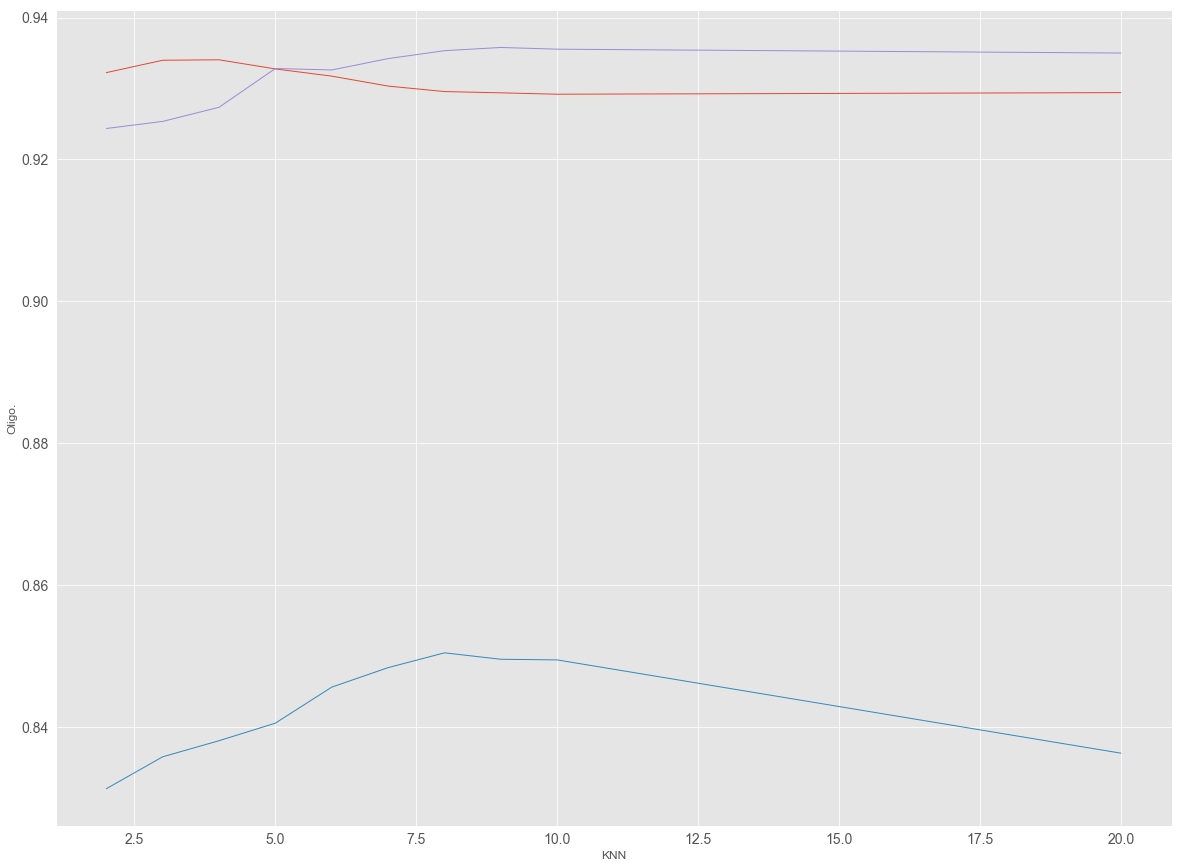

In [68]:
all_rocs = pd.concat([pd.DataFrame(roc_2),pd.DataFrame(roc_3),pd.DataFrame(roc_4),pd.DataFrame(roc_5),pd.DataFrame(roc_6),
           pd.DataFrame(roc_7),pd.DataFrame(roc_8),pd.DataFrame(roc_9),pd.DataFrame(roc_10),pd.DataFrame(roc_20)], 
          axis = 1)
all_rocs.columns = [2,3,4,5,6,7,8,9,10,20]
all_rocs.index = ['GBMvsIDH','Oligo.','Astro.']
all_rocs = all_rocs.T
all_rocs['KNN'] = all_rocs.index 
ax = sns.lineplot(x="KNN", y="GBMvsIDH", estimator=None, lw=1,
                  data=all_rocs)
sns.lineplot(x="KNN", y="Astro.", estimator=None, lw=1,
                  data=all_rocs)
sns.lineplot(x="KNN", y="Oligo.", estimator=None, lw=1,
                  data=all_rocs)

In [69]:
roc_C8 = test_k(C = 1000)
roc_C1 = test_k(C = 100)
roc_C2 = test_k(C = 10)
roc_C3 = test_k(C = 1)
roc_C4 = test_k(C = 0.1)
roc_C5 = test_k(C = 0.01)
roc_C6 = test_k(C = 0.001)
roc_C7 = test_k(C = 0.0001)


//anaconda3/lib/python3.7/site-packages/fancyimpute/solver.py:55: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")


Imputing row 1/1584 with 0 missing, elapsed time: 11.645
Imputing row 101/1584 with 0 missing, elapsed time: 11.646
Imputing row 201/1584 with 0 missing, elapsed time: 11.646
Imputing row 301/1584 with 0 missing, elapsed time: 11.647
Imputing row 401/1584 with 0 missing, elapsed time: 11.648
Imputing row 501/1584 with 0 missing, elapsed time: 11.649
Imputing row 601/1584 with 0 missing, elapsed time: 11.649
Imputing row 701/1584 with 0 missing, elapsed time: 11.651
Imputing row 801/1584 with 0 missing, elapsed time: 11.651
Imputing row 901/1584 with 0 missing, elapsed time: 11.652
Imputing row 1001/1584 with 0 missing, elapsed time: 11.653
Imputing row 1101/1584 with 0 missing, elapsed time: 11.653
Imputing row 1201/1584 with 0 missing, elapsed time: 11.654
Imputing row 1301/1584 with 0 missing, elapsed time: 11.655
Imputing row 1401/1584 with 0 missing, elapsed time: 11.656
Imputing row 1501/1584 with 0 missing, elapsed time: 11.657
Imputing row 1/1156 with 798 missing, elapsed time: 

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Imputing row 1/1584 with 0 missing, elapsed time: 10.663
Imputing row 101/1584 with 0 missing, elapsed time: 10.664
Imputing row 201/1584 with 0 missing, elapsed time: 10.665
Imputing row 301/1584 with 0 missing, elapsed time: 10.665
Imputing row 401/1584 with 0 missing, elapsed time: 10.666
Imputing row 501/1584 with 0 missing, elapsed time: 10.666
Imputing row 601/1584 with 0 missing, elapsed time: 10.667
Imputing row 701/1584 with 0 missing, elapsed time: 10.668
Imputing row 801/1584 with 0 missing, elapsed time: 10.669
Imputing row 901/1584 with 0 missing, elapsed time: 10.670
Imputing row 1001/1584 with 0 missing, elapsed time: 10.671
Imputing row 1101/1584 with 0 missing, elapsed time: 10.671
Imputing row 1201/1584 with 0 missing, elapsed time: 10.672
Imputing row 1301/1584 with 0 missing, elapsed time: 10.672
Imputing row 1401/1584 with 0 missing, elapsed time: 10.673
Imputing row 1501/1584 with 0 missing, elapsed time: 10.673
Imputing row 1/1156 with 798 missing, elapsed time: 

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Imputing row 1/1584 with 0 missing, elapsed time: 10.661
Imputing row 101/1584 with 0 missing, elapsed time: 10.661
Imputing row 201/1584 with 0 missing, elapsed time: 10.662
Imputing row 301/1584 with 0 missing, elapsed time: 10.663
Imputing row 401/1584 with 0 missing, elapsed time: 10.664
Imputing row 501/1584 with 0 missing, elapsed time: 10.664
Imputing row 601/1584 with 0 missing, elapsed time: 10.665
Imputing row 701/1584 with 0 missing, elapsed time: 10.666
Imputing row 801/1584 with 0 missing, elapsed time: 10.666
Imputing row 901/1584 with 0 missing, elapsed time: 10.667
Imputing row 1001/1584 with 0 missing, elapsed time: 10.668
Imputing row 1101/1584 with 0 missing, elapsed time: 10.668
Imputing row 1201/1584 with 0 missing, elapsed time: 10.669
Imputing row 1301/1584 with 0 missing, elapsed time: 10.669
Imputing row 1401/1584 with 0 missing, elapsed time: 10.670
Imputing row 1501/1584 with 0 missing, elapsed time: 10.670
Imputing row 1/1156 with 798 missing, elapsed time: 

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Imputing row 1/1584 with 0 missing, elapsed time: 12.899
Imputing row 101/1584 with 0 missing, elapsed time: 12.901
Imputing row 201/1584 with 0 missing, elapsed time: 12.902
Imputing row 301/1584 with 0 missing, elapsed time: 12.902
Imputing row 401/1584 with 0 missing, elapsed time: 12.903
Imputing row 501/1584 with 0 missing, elapsed time: 12.904
Imputing row 601/1584 with 0 missing, elapsed time: 12.905
Imputing row 701/1584 with 0 missing, elapsed time: 12.906
Imputing row 801/1584 with 0 missing, elapsed time: 12.906
Imputing row 901/1584 with 0 missing, elapsed time: 12.907
Imputing row 1001/1584 with 0 missing, elapsed time: 12.908
Imputing row 1101/1584 with 0 missing, elapsed time: 12.909
Imputing row 1201/1584 with 0 missing, elapsed time: 12.910
Imputing row 1301/1584 with 0 missing, elapsed time: 12.910
Imputing row 1401/1584 with 0 missing, elapsed time: 12.911
Imputing row 1501/1584 with 0 missing, elapsed time: 12.912
Imputing row 1/1156 with 798 missing, elapsed time: 

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Imputing row 1/1584 with 0 missing, elapsed time: 11.098
Imputing row 101/1584 with 0 missing, elapsed time: 11.099
Imputing row 201/1584 with 0 missing, elapsed time: 11.100
Imputing row 301/1584 with 0 missing, elapsed time: 11.100
Imputing row 401/1584 with 0 missing, elapsed time: 11.101
Imputing row 501/1584 with 0 missing, elapsed time: 11.102
Imputing row 601/1584 with 0 missing, elapsed time: 11.102
Imputing row 701/1584 with 0 missing, elapsed time: 11.103
Imputing row 801/1584 with 0 missing, elapsed time: 11.104
Imputing row 901/1584 with 0 missing, elapsed time: 11.104
Imputing row 1001/1584 with 0 missing, elapsed time: 11.105
Imputing row 1101/1584 with 0 missing, elapsed time: 11.105
Imputing row 1201/1584 with 0 missing, elapsed time: 11.106
Imputing row 1301/1584 with 0 missing, elapsed time: 11.107
Imputing row 1401/1584 with 0 missing, elapsed time: 11.107
Imputing row 1501/1584 with 0 missing, elapsed time: 11.108
Imputing row 1/1156 with 798 missing, elapsed time: 

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Imputing row 1/1584 with 0 missing, elapsed time: 10.596
Imputing row 101/1584 with 0 missing, elapsed time: 10.597
Imputing row 201/1584 with 0 missing, elapsed time: 10.597
Imputing row 301/1584 with 0 missing, elapsed time: 10.598
Imputing row 401/1584 with 0 missing, elapsed time: 10.599
Imputing row 501/1584 with 0 missing, elapsed time: 10.600
Imputing row 601/1584 with 0 missing, elapsed time: 10.600
Imputing row 701/1584 with 0 missing, elapsed time: 10.601
Imputing row 801/1584 with 0 missing, elapsed time: 10.601
Imputing row 901/1584 with 0 missing, elapsed time: 10.602
Imputing row 1001/1584 with 0 missing, elapsed time: 10.603
Imputing row 1101/1584 with 0 missing, elapsed time: 10.603
Imputing row 1201/1584 with 0 missing, elapsed time: 10.604
Imputing row 1301/1584 with 0 missing, elapsed time: 10.604
Imputing row 1401/1584 with 0 missing, elapsed time: 10.605
Imputing row 1501/1584 with 0 missing, elapsed time: 10.606
Imputing row 1/1156 with 798 missing, elapsed time: 

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Imputing row 1/1584 with 0 missing, elapsed time: 10.631
Imputing row 101/1584 with 0 missing, elapsed time: 10.632
Imputing row 201/1584 with 0 missing, elapsed time: 10.633
Imputing row 301/1584 with 0 missing, elapsed time: 10.633
Imputing row 401/1584 with 0 missing, elapsed time: 10.634
Imputing row 501/1584 with 0 missing, elapsed time: 10.635
Imputing row 601/1584 with 0 missing, elapsed time: 10.635
Imputing row 701/1584 with 0 missing, elapsed time: 10.636
Imputing row 801/1584 with 0 missing, elapsed time: 10.636
Imputing row 901/1584 with 0 missing, elapsed time: 10.637
Imputing row 1001/1584 with 0 missing, elapsed time: 10.638
Imputing row 1101/1584 with 0 missing, elapsed time: 10.638
Imputing row 1201/1584 with 0 missing, elapsed time: 10.639
Imputing row 1301/1584 with 0 missing, elapsed time: 10.640
Imputing row 1401/1584 with 0 missing, elapsed time: 10.640
Imputing row 1501/1584 with 0 missing, elapsed time: 10.641
Imputing row 1/1156 with 798 missing, elapsed time: 

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Imputing row 1/1584 with 0 missing, elapsed time: 10.674
Imputing row 101/1584 with 0 missing, elapsed time: 10.675
Imputing row 201/1584 with 0 missing, elapsed time: 10.675
Imputing row 301/1584 with 0 missing, elapsed time: 10.676
Imputing row 401/1584 with 0 missing, elapsed time: 10.677
Imputing row 501/1584 with 0 missing, elapsed time: 10.677
Imputing row 601/1584 with 0 missing, elapsed time: 10.678
Imputing row 701/1584 with 0 missing, elapsed time: 10.678
Imputing row 801/1584 with 0 missing, elapsed time: 10.679
Imputing row 901/1584 with 0 missing, elapsed time: 10.680
Imputing row 1001/1584 with 0 missing, elapsed time: 10.680
Imputing row 1101/1584 with 0 missing, elapsed time: 10.681
Imputing row 1201/1584 with 0 missing, elapsed time: 10.682
Imputing row 1301/1584 with 0 missing, elapsed time: 10.682
Imputing row 1401/1584 with 0 missing, elapsed time: 10.683
Imputing row 1501/1584 with 0 missing, elapsed time: 10.684
Imputing row 1/1156 with 798 missing, elapsed time: 

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

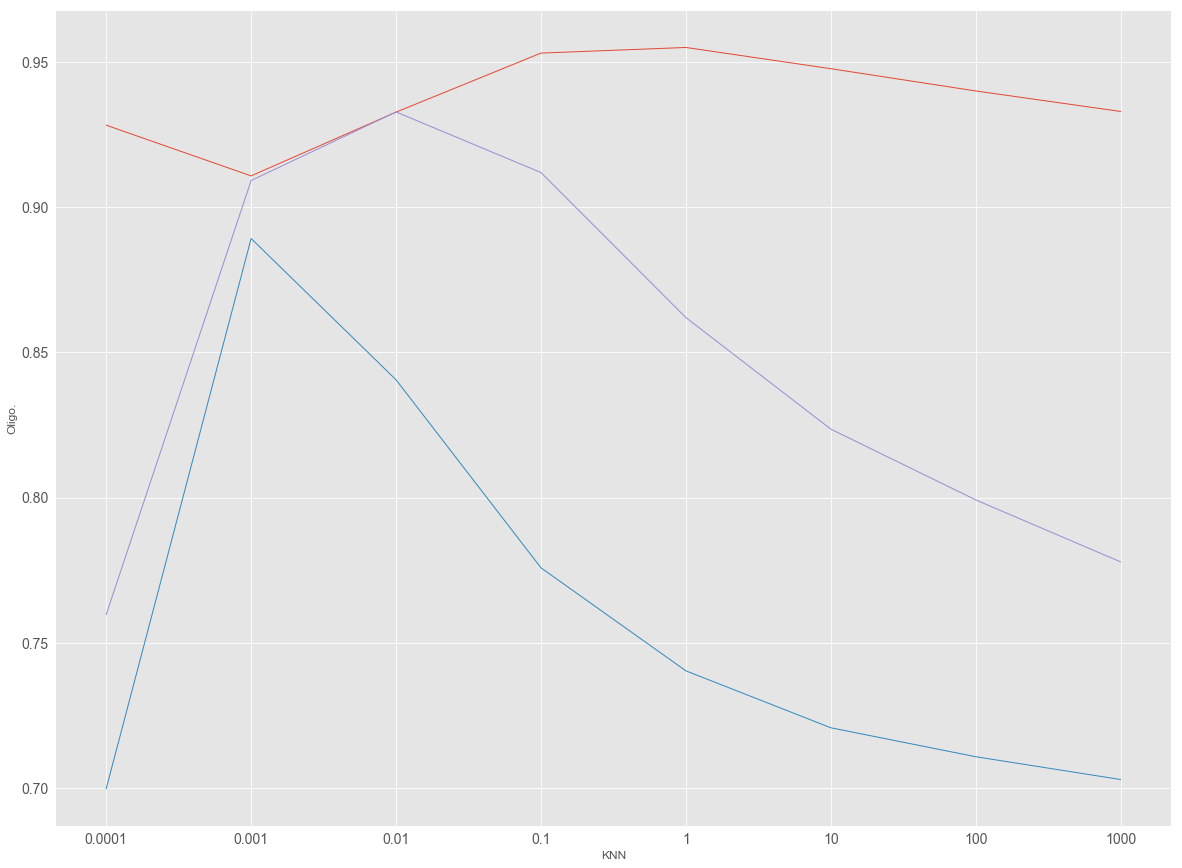

In [70]:
all_rocs = pd.concat([pd.DataFrame(roc_C1),pd.DataFrame(roc_C2),pd.DataFrame(roc_C3),pd.DataFrame(roc_C4),pd.DataFrame(roc_C5),
           pd.DataFrame(roc_C6),pd.DataFrame(roc_C7),pd.DataFrame(roc_C8)], 
          axis = 1)
all_rocs.columns = ['1000','100','10','1','0.1','0.01','0.001','0.0001']
all_rocs.index = ['GBMvsIDH','Oligo.','Astro.']
all_rocs = all_rocs.T
all_rocs['KNN'] = all_rocs.index 
ax = sns.lineplot(x="KNN", y="GBMvsIDH", estimator=None, lw=1,
                  data=all_rocs)
sns.lineplot(x="KNN", y="Astro.", estimator=None, lw=1,
                  data=all_rocs)
sns.lineplot(x="KNN", y="Oligo.", estimator=None, lw=1,
                  data=all_rocs)

# Train just IDHs

In [71]:
just_idh = (Y <= 2)

In [72]:
from sklearn.model_selection import cross_val_score

c_range = [1000000,100000,10000,1000,100,10,1,0.1,0.01,0.001,0.0001]

# empty list to store scores
C_scores = []

# we will loop through reasonable values of k
for c in c_range:

    # Train with currrent C
    logisticRegr = LogisticRegression(C = c)
    
    # obtain cross_val_score for logictic regression with current C
    scores = cross_val_score(logisticRegr, bulk_zscore_imputed[just_idh], Y[just_idh], cv=10, scoring='balanced_accuracy')
    
    # 4. append mean of scores for C neighbors to C_scores list
    C_scores.append(scores.mean())
    

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be ch

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be ch

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be ch

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be ch

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be ch

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be ch

([<matplotlib.axis.XTick at 0x1c32c32990>,
 <a list of 11 Text xticklabel objects>)

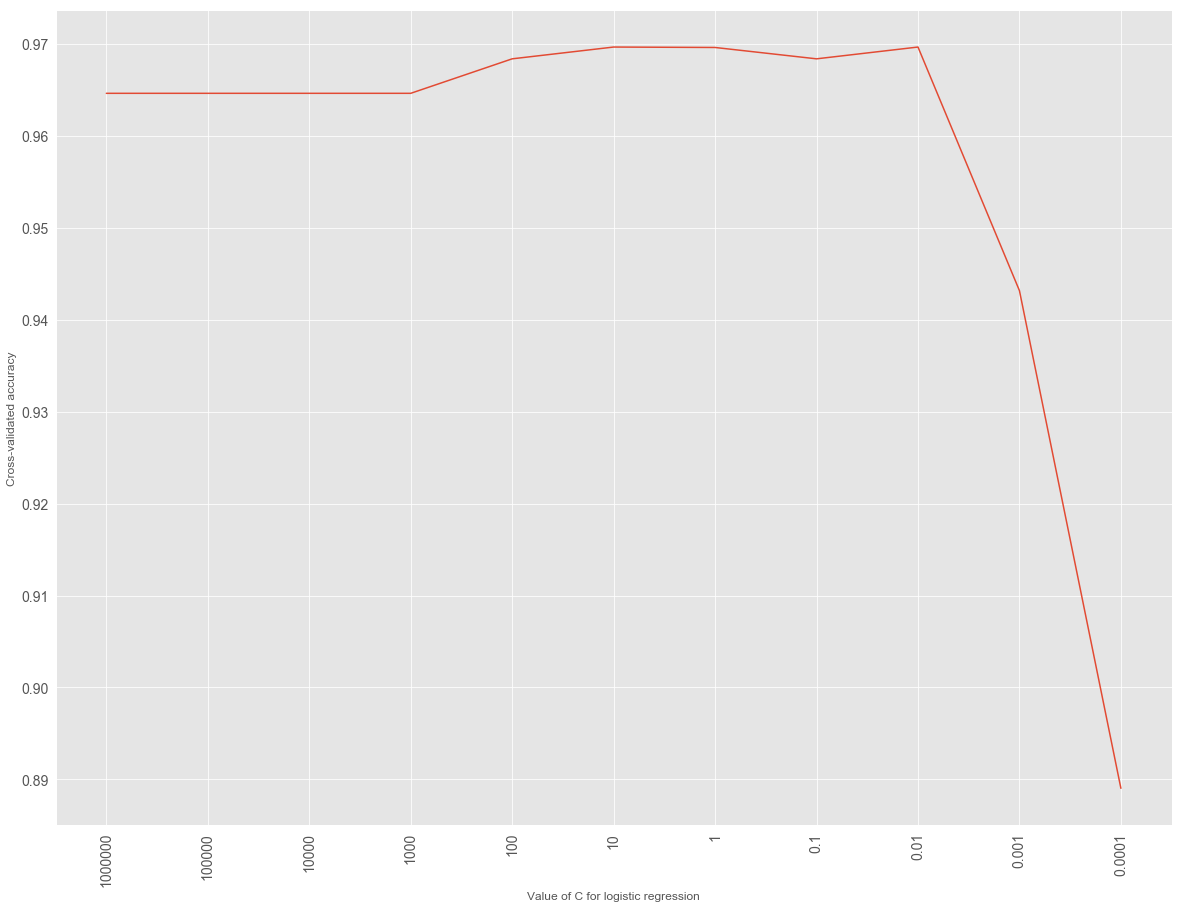

In [73]:
plt.plot(range(0,len(c_range)), C_scores)
plt.xlabel('Value of C for logistic regression')
plt.ylabel('Cross-validated accuracy')
plt.xticks(range(0,len(c_range)), c_range, rotation='vertical')

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


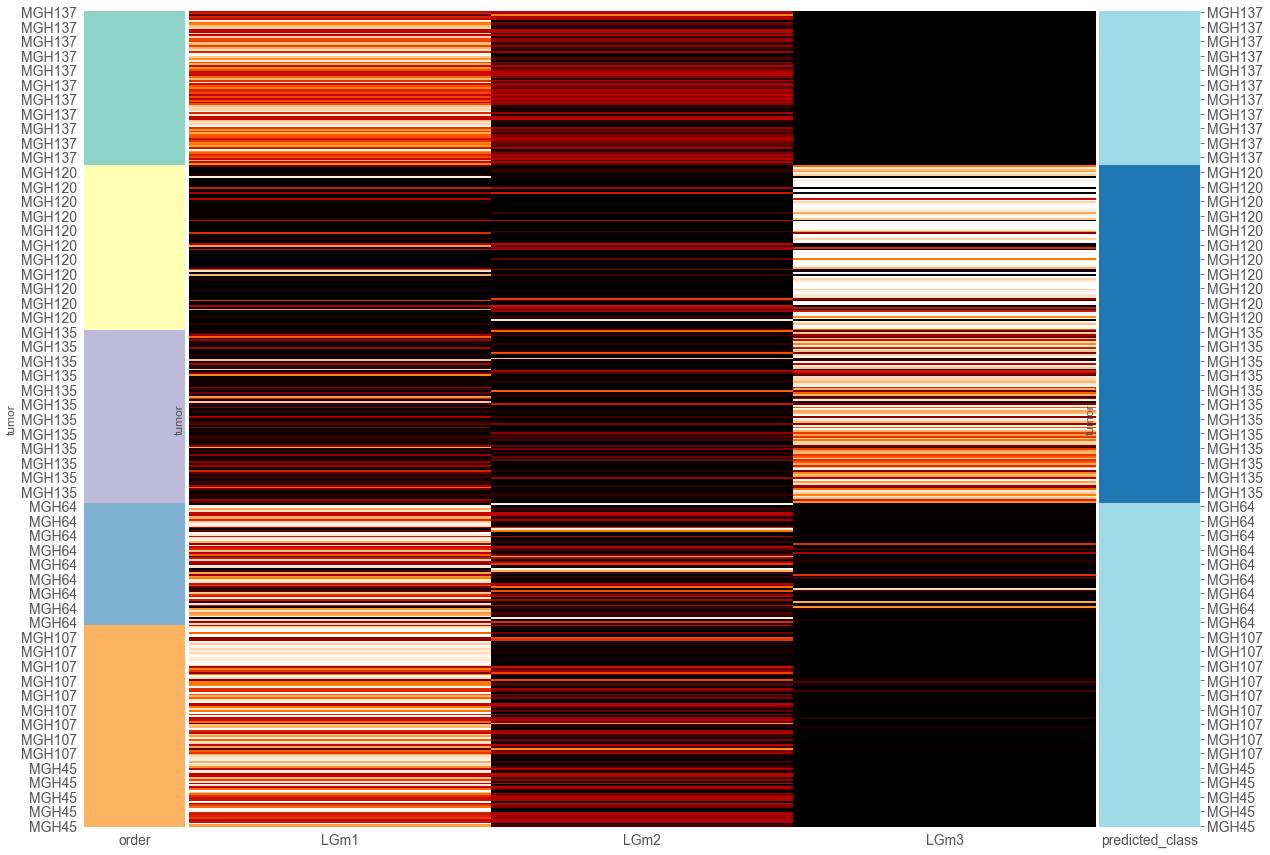

In [74]:
C = 1
logisticRegr = LogisticRegression(C = C)
logisticRegr.fit(bulk_zscore_imputed[just_idh], Y[just_idh])
sc_proba = logisticRegr.predict_proba(sc_zcore_imputed)
results = pd.concat([sc_tumor, pd.DataFrame(sc_proba)], axis = 1)
results['filename'] = sc_zscore.index
results['Y'] = results['tumor'].map(classifier_dict)
results = results[results['Y'] != "WT"]
results.columns= ['tumor','LGm1','LGm2','LGm3','filename','Y']
results['predicted_class'] = label_encoder.fit_transform(results['Y'])
custom_dict = {'MGH105A':1,'MGH105B':2,'MGH105C':3,'MGH105D':4,'MGH105Cmacrophage':5,'MGH115':6,
               'MGH121Plate1':7, 'MGH121Plate2':8,'MGH121Plate3':9, 'MGH121Plate4':10, 'MGH122':13, 'MGH124':12, 
               'MGH129':11,'MGH137':14,'MGH120':15,'MGH135':16,'MGH170':17,'MGH64':18,'MGH107':19,'MGH45':20}
results['order'] = [custom_dict[k] for k in results['tumor']]
results = results.sort_values('order')
results.index = results['tumor']
results['filename'] = results['filename'].str.rstrip(".R1.fastq_bismark_bt2_pe.bismark.cov")
results['filename'] = results['filename'].replace({'Plate':'_Plate'}, regex=True)


fig, (ax,ax2,ax3) = plt.subplots(ncols=3, gridspec_kw={'width_ratios': [1, 9,1]})
fig.subplots_adjust(wspace=0.01)
sns.heatmap(results[['order']], ax=ax, cbar=False,cmap=sns.color_palette("Set3", len(results[['order']].drop_duplicates())))
sns.heatmap(results[['LGm1','LGm2','LGm3']], ax=ax2, cbar=False, yticklabels = False,cmap='gist_heat')
sns.heatmap(results[['predicted_class']], ax=ax3, cbar=False,cmap="tab20")

#fig.colorbar(ax2.collections[0], location="right", use_gridspec=False, pad=0.3)
ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
ax3.yaxis.tick_right()
ax3.tick_params(rotation=0)
#plt.savefig(figures_dir + "heatmap_tiles"+ tiles +"C" + str(C).replace(".","_") + ".pdf")
plt.show()

#### Predict for pseudo bulk

In [75]:
sc_proba = logisticRegr.predict_proba(pseudo_bulk_imputed)
bulk_results = pd.concat([pd.DataFrame(np.unique(sc_tumor)), pd.DataFrame(sc_proba)], axis = 1)
bulk_results.columns = ['tumor','LGm1','LGm2','LGm3']


In [76]:
# Add coverage
sc_coverage = pd.DataFrame((~df_sc.isnull()).sum(axis = 1))
sc_coverage.index = sc_coverage.index.str.rstrip(".R1.fastq_bismark_bt2_pe.bismark.cov")
sc_coverage = sc_coverage.reset_index()
sc_coverage.columns = ['filename','covered']
sc_coverage['filename'] = sc_coverage['filename'].replace({'Plate':'_Plate'}, regex=True)
results = results.merge(sc_coverage, how = 'left')

In [77]:
tumor_name = "MGH135"
tumor_results = results[(results['tumor'].str.startswith(tumor_name)) & (results['tumor'] != "MGH105Cmacrophage")][['LGm1','LGm2','LGm3','covered','filename']]

In [78]:
from math import sqrt

root3 = sqrt(3)

# the scale used for drawing
side = 50

# Convert hex coordinates to rectangular
def hex_to_rect(coord):
    u, v, w = coord
    x = u - v/2 - w/2
    y = (v - w) * root3 / 2
    return x * side, y * side


coords = [[0,1,-1], [-1,1,0], [-1,0,1], [0,-1,1], [1,-1,0], [1,0,-1]]
colors = ['red', 'orange', 'green', 'cyan', 'blue', 'magenta']

def rescale(values, old_min, old_max, new_min = -1, new_max = 1):
    output = []

    for v in values:
        new_v = (new_max - new_min) / (old_max - old_min) * (v - old_min) + new_min
        output.append(new_v)

    return output
all_classes_min = tumor_results[['LGm1','LGm2','LGm3']].min().min()
all_classes_max = tumor_results[['LGm1','LGm2','LGm3']].max().max()
tumor_results['LGm1'] = rescale(tumor_results['LGm1'], all_classes_min, all_classes_max)
tumor_results['LGm2'] = rescale(tumor_results['LGm2'], all_classes_min, all_classes_max)
tumor_results['LGm3'] = rescale(tumor_results['LGm3'], all_classes_min, all_classes_max)

df_xy = pd.DataFrame([hex_to_rect(hexcoord) for hexcoord in (tumor_results[['LGm1','LGm2','LGm3']]).as_matrix()])

bulk_max = bulk_results[['LGm1','LGm2','LGm3']].max().max()
bulk_min = bulk_results[['LGm1','LGm2','LGm3']].min().min()
bulk_coordinates = bulk_results[bulk_results['tumor'] == tumor_name][['LGm1','LGm2','LGm3']].reset_index().as_matrix().flatten()[1:4]
bulk_coordinates = rescale(bulk_coordinates[0:3], bulk_min, bulk_max)
bulk_coordinates = hex_to_rect(bulk_coordinates)


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


//anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
//anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


Text(0.5, 0.98, 'MGH135')

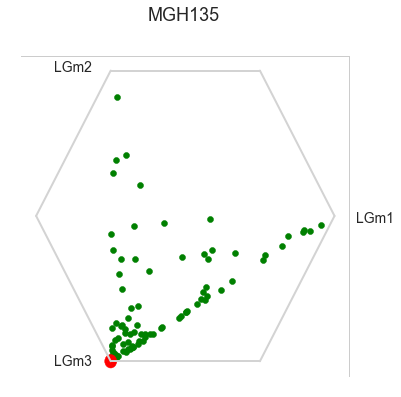

In [79]:
#### sns.scatterplot(df_xy[0], df_xy[1])
sns.set_style("whitegrid")
grid = sns.JointGrid(df_xy[0], df_xy[1], space=0, size=6, ratio=50)
h = grid.plot_joint(plt.scatter, color="g")
g1 = plt.plot([-50, -100], [86.60254, 0], linewidth=2, color = 'lightgrey')
g2 = plt.plot([-100, -50], [0, -86.60254], linewidth=2, color = 'lightgrey')
g3 = plt.plot([-50, 50], [-86.60254,-86.60254], linewidth=2, color = 'lightgrey')
g4 = plt.plot([50, 100], [-86.60254, 0], linewidth=2, color = 'lightgrey')
g5 = plt.plot([100, 50], [0, 86.60254], linewidth=2, color = 'lightgrey')
g6 = plt.plot([-50, 50], [86.60254, 86.60254], linewidth=2, color = 'lightgrey')
# text is left-aligned
#plt.text(bulk_coordinates[0],bulk_coordinates[1],'   Bulk', color = 'red')
circle1 = plt.Circle(bulk_coordinates, 4, color='r')
plt.gcf().gca().add_artist(circle1)
plt.text(0.2, 0.83, "LGm2", fontsize=14, transform=plt.gcf().transFigure)
plt.text(0.2, 0.15, "LGm3", fontsize=14, transform=plt.gcf().transFigure)
plt.text(0.9, 0.48, "LGm1", fontsize=14, transform=plt.gcf().transFigure)
h.ax_joint.axis('off')
h.ax_joint.set_xticks([])
h.ax_joint.set_yticks([])
h.fig.suptitle(tumor_name)

//anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
//anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


Text(0.5, 0.98, 'MGH135')

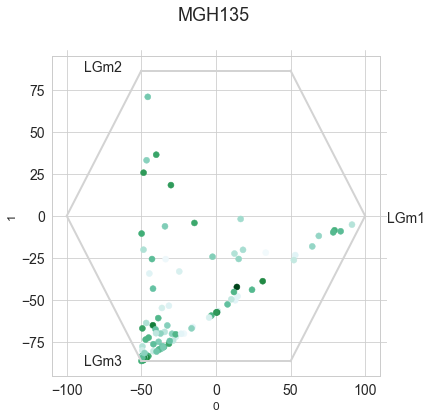

In [80]:
cmap = "BuGn"
# sns.scatterplot(df_xy[0], df_xy[1])
sns.set_style("whitegrid")
grid = sns.JointGrid(df_xy[0], df_xy[1], space=0, size=6, ratio=50)
h = grid.plot_joint(plt.scatter, c = tumor_results['covered']/1000, cmap = cmap)
g1 = plt.plot([-50, -100], [86.60254, 0], linewidth=2, color = 'lightgrey')
g2 = plt.plot([-100, -50], [0, -86.60254], linewidth=2, color = 'lightgrey')
g3 = plt.plot([-50, 50], [-86.60254,-86.60254], linewidth=2, color = 'lightgrey')
g4 = plt.plot([50, 100], [-86.60254, 0], linewidth=2, color = 'lightgrey')
g5 = plt.plot([100, 50], [0, 86.60254], linewidth=2, color = 'lightgrey')
g6 = plt.plot([-50, 50], [86.60254, 86.60254], linewidth=2, color = 'lightgrey')
plt.text(0.2, 0.83, "LGm2", fontsize=14, transform=plt.gcf().transFigure)
plt.text(0.2, 0.15, "LGm3", fontsize=14, transform=plt.gcf().transFigure)
plt.text(0.9, 0.48, "LGm1", fontsize=14, transform=plt.gcf().transFigure)
#h.ax_joint.axis('off')
#h.ax_joint.set_xticks([])
#h.ax_joint.set_yticks([])
h.fig.suptitle(tumor_name)

# Train just GBM

In [84]:
just_idh = np.full(len(Y), True, dtype=bool)


In [85]:
just_idh = (Y > 2)

In [86]:
results['tumor'].unique()

array(['MGH137', 'MGH120', 'MGH135', 'MGH64', 'MGH107', 'MGH45'],
      dtype=object)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


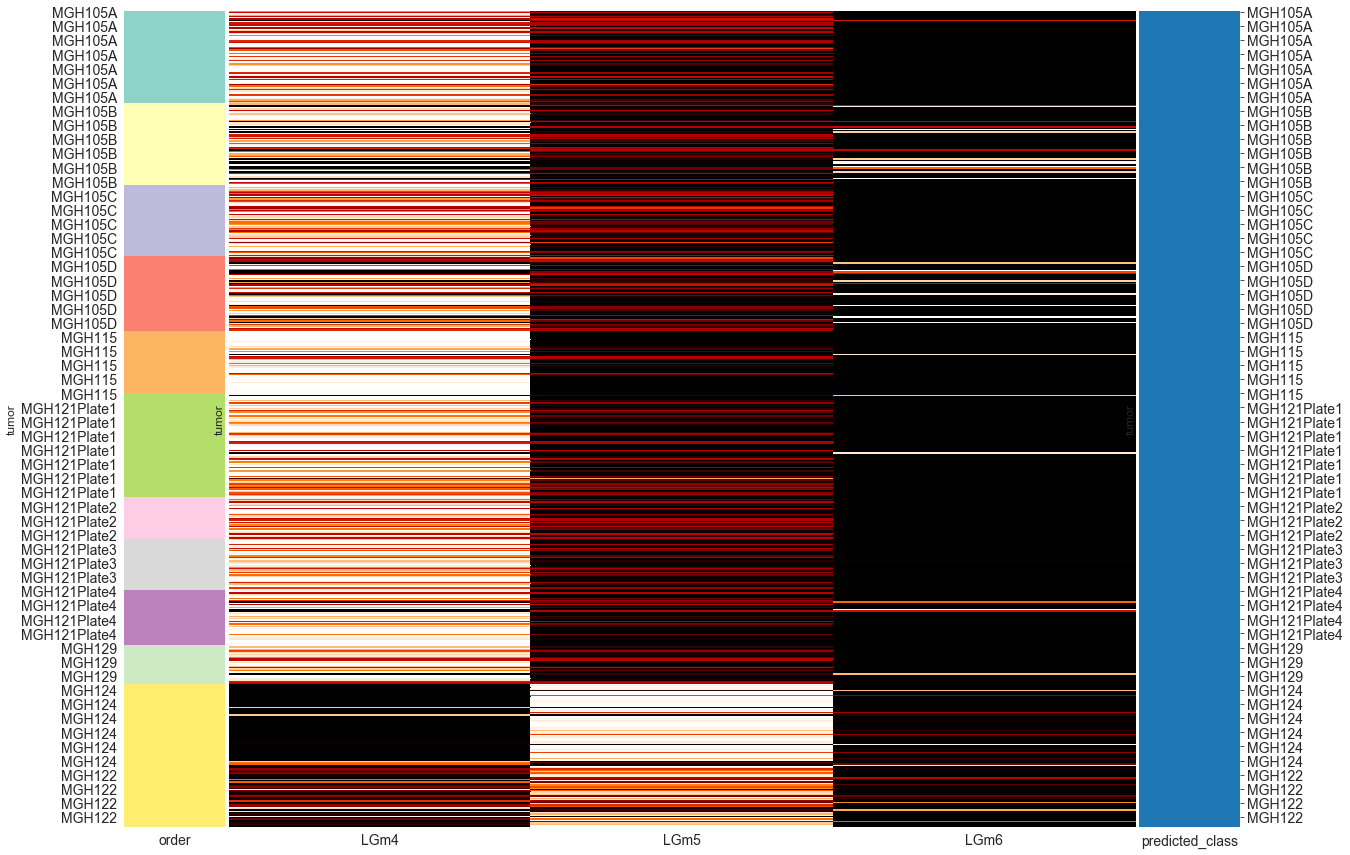

In [87]:
C = 10
logisticRegr = LogisticRegression(C = C)
logisticRegr.fit(bulk_zscore_imputed[just_idh], Y[just_idh])
sc_proba = logisticRegr.predict_proba(sc_zcore_imputed)
results = pd.concat([sc_tumor, pd.DataFrame(sc_proba)], axis = 1)
results['filename'] = sc_zscore.index
results['Y'] = results['tumor'].map(classifier_dict)
results = results[(results['Y'] == "WT") & (results['tumor'] != 'MGH105Cmacrophage')]
results.columns= ['tumor','LGm4','LGm5','LGm6','filename','Y']
results['predicted_class'] = label_encoder.fit_transform(results['Y'])
custom_dict = {'MGH105A':1,'MGH105B':2,'MGH105C':3,'MGH105D':4,'MGH105Cmacrophage':5,'MGH115':6,
               'MGH121Plate1':7, 'MGH121Plate2':8,'MGH121Plate3':9, 'MGH121Plate4':10, 'MGH122':13, 'MGH124':12, 
               'MGH129':11,'MGH137':14,'MGH120':15,'MGH135':16,'MGH170':17,'MGH64':18,'MGH107':19,'MGH45':20}
results['order'] = [custom_dict[k] for k in results['tumor']]
results = results.sort_values('order')
results.index = results['tumor']
results['filename'] = results['filename'].str.rstrip(".R1.fastq_bismark_bt2_pe.bismark.cov")
results['filename'] = results['filename'].replace({'Plate':'_Plate'}, regex=True)


fig, (ax,ax2,ax3) = plt.subplots(ncols=3, gridspec_kw={'width_ratios': [1, 9,1]})
fig.subplots_adjust(wspace=0.01)
sns.heatmap(results[['order']], ax=ax, cbar=False,cmap=sns.color_palette("Set3", len(results[['order']].drop_duplicates())))
sns.heatmap(results[['LGm4','LGm5','LGm6']], ax=ax2, cbar=False, yticklabels = False,cmap='gist_heat')
sns.heatmap(results[['predicted_class']], ax=ax3, cbar=False,cmap="tab20")

#fig.colorbar(ax2.collections[0], location="right", use_gridspec=False, pad=0.3)
ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
ax3.yaxis.tick_right()
ax3.tick_params(rotation=0)
#plt.savefig(figures_dir + "heatmap_tiles"+ tiles +"C" + str(C).replace(".","_") + ".pdf")
plt.show()

In [88]:
sc_proba = logisticRegr.predict_proba(pseudo_bulk_imputed)
bulk_results = pd.concat([pd.DataFrame(np.unique(sc_tumor)), pd.DataFrame(sc_proba)], axis = 1)
bulk_results.columns = ['tumor','LGm4','LGm5','LGm6']
bulk_results['sample'] = bulk_results['tumor']
bulk_results['sample'] = bulk_results['sample'].replace("MGH121Plate1","MGH121")
bulk_results['sample'] = bulk_results['sample'].replace("MGH121Plate2","MGH121")
bulk_results['sample'] = bulk_results['sample'].replace("MGH121Plate3","MGH121")
bulk_results['sample'] = bulk_results['sample'].replace("MGH121Plate4","MGH121")

bulk_results['sample'] = bulk_results['sample'].replace("MGH105A","MGH105")
bulk_results['sample'] = bulk_results['sample'].replace("MGH105B","MGH105")
bulk_results['sample'] = bulk_results['sample'].replace("MGH105C","MGH105")
bulk_results['sample'] = bulk_results['sample'].replace("MGH105D","MGH105")

In [89]:
# Add coverage
sc_coverage = pd.DataFrame((~df_sc.isnull()).sum(axis = 1))
sc_coverage.index = sc_coverage.index.str.rstrip(".R1.fastq_bismark_bt2_pe.bismark.cov")
sc_coverage = sc_coverage.reset_index()
sc_coverage.columns = ['filename','covered']
sc_coverage['filename'] = sc_coverage['filename'].replace({'Plate':'_Plate'}, regex=True)
results = results.merge(sc_coverage, how = 'left')

In [90]:
tumor_name = "MGH122"
tumor_results = results[(results['tumor'].str.startswith(tumor_name)) & (results['tumor'] != "MGH105Cmacrophage")][['LGm4','LGm5','LGm6','covered','filename']]

In [91]:
all_classes_min = tumor_results[['LGm4','LGm5','LGm6']].min().min()
all_classes_max = tumor_results[['LGm4','LGm5','LGm6']].max().max()
tumor_results['LGm4'] = rescale(tumor_results['LGm4'], all_classes_min, all_classes_max)
tumor_results['LGm5'] = rescale(tumor_results['LGm5'], all_classes_min, all_classes_max)
tumor_results['LGm6'] = rescale(tumor_results['LGm6'], all_classes_min, all_classes_max)

df_xy = pd.DataFrame([hex_to_rect(hexcoord) for hexcoord in (tumor_results[['LGm4','LGm5','LGm6']]).as_matrix()])

bulk_max = bulk_results[['LGm4','LGm5','LGm6']].max().max()
bulk_min = bulk_results[['LGm4','LGm5','LGm6']].min().min()
bulk_coordinates = bulk_results[bulk_results['sample'] == tumor_name][['LGm4','LGm5','LGm6']].reset_index().as_matrix().flatten()[1:4]
bulk_coordinates = rescale(bulk_coordinates[0:3], bulk_min, bulk_max)
bulk_coordinates = hex_to_rect(bulk_coordinates)


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


//anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
//anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


Text(0.5, 0.98, 'MGH122')

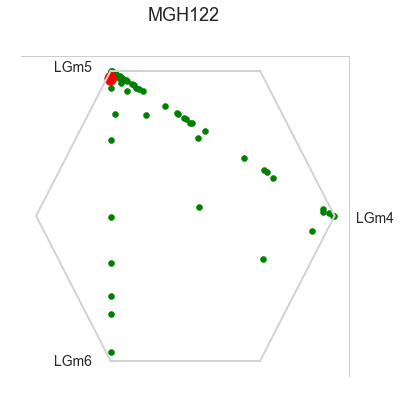

In [92]:
#### sns.scatterplot(df_xy[0], df_xy[1])
sns.set_style("whitegrid")
grid = sns.JointGrid(df_xy[0], df_xy[1], space=0, size=6, ratio=50)
h = grid.plot_joint(plt.scatter, color="g")
g1 = plt.plot([-50, -100], [86.60254, 0], linewidth=2, color = 'lightgrey')
g2 = plt.plot([-100, -50], [0, -86.60254], linewidth=2, color = 'lightgrey')
g3 = plt.plot([-50, 50], [-86.60254,-86.60254], linewidth=2, color = 'lightgrey')
g4 = plt.plot([50, 100], [-86.60254, 0], linewidth=2, color = 'lightgrey')
g5 = plt.plot([100, 50], [0, 86.60254], linewidth=2, color = 'lightgrey')
g6 = plt.plot([-50, 50], [86.60254, 86.60254], linewidth=2, color = 'lightgrey')
# text is left-aligned
#plt.text(bulk_coordinates[0],bulk_coordinates[1],'   Bulk', color = 'red')
circle1 = plt.Circle(bulk_coordinates, 4, color='r')
plt.gcf().gca().add_artist(circle1)
plt.text(0.2, 0.83, "LGm5", fontsize=14, transform=plt.gcf().transFigure)
plt.text(0.2, 0.15, "LGm6", fontsize=14, transform=plt.gcf().transFigure)
plt.text(0.9, 0.48, "LGm4", fontsize=14, transform=plt.gcf().transFigure)
h.ax_joint.axis('off')
h.ax_joint.set_xticks([])
h.ax_joint.set_yticks([])
h.fig.suptitle(tumor_name)